In [6]:
using Pkg
Pkg.activate(".")
using BenchmarkTools
import Markdown 
Base.showable(::MIME"text/markdown", ::Markdown.MD) =false # same function as below
include("bnc_initialize.jl")
# BLAS.set_num_threads(16) # set number of threads for BLAS

# to make sth like """?replace"""  works for vscode backend, remember to choose Jupyter kernel

  Activating project at `~/Realizibility_index/bnc_julia`


LoadError: LoadError: invalid redefinition of type Bnc
in expression starting at /home/joker/Realizibility_index/bnc_julia/bnc_initialize.jl:129

In [6]:
# using LinearAlgebra, JuMP, HiGHS

"""
    find_interface_normal(C1, C01, C2, C02; eps=1e-8)

自动寻找两个 regime 的交界超平面，并返回：
- n0: 单位法向量（指向 regime1 的一侧）
- c0: 平面距离原点的shift
- active_rows: 哪些约束是紧约束

要求：交界的法向空间必须是一维，否则报错。
"""
function find_interface_normal(C1, C2; eps=1e-8)
    m1, n = size(C1)
    m2, _ = size(C2)

    function form_superplane(c1, c2; tol=1e-9)
        k = nothing
        for a in 1:length(c1)
            i, j = c1[a], c2[a]
            if (i == 0 && j != 0) || (i != 0 && j == 0)
                return false
            elseif i == 0 && j == 0
                continue
            end
            k_new = i/j
            if k_new > 0
                return false
            elseif k === nothing
                k = k_new
            elseif abs(k_new - k) > tol
                return false
            end
        end
        return k !== nothing
    end

    # Step 1: 枚举所有候选行对
    found_c2 = nothing
    # found_c01 = nothing
    found_idx = nothing
    count = 0
    for i in 1:m1
        for j in 1:m2
            c1 = C1[i,:]#, C01[i]
            c2 = C2[j,:]#, C02[j]
            if form_superplane(c1, c2)
                count += 1
                @show Array(c1), Array(c2)
                if count > 1
                    error("找到了多个候选的 1D 公共法向量")
                end
                found_c2, found_idx = c2, (i,j)
            end
        end
    end
    
    if count == 0
        error("没有找到唯一的 1D 公共法向量")
    else
        return (found_c2, found_idx)
    end
end



find_interface_normal

In [7]:
function find_direction_direct(Bnc::Bnc{T},from,to) where T
    (C1,_) = get_C_C0_qK!(model,vtx1)
    (C2,_) = get_C_C0_qK!(model,vtx2)
    find_interface_normal(C1,C2)
end

find_direction_direct (generic function with 1 method)

In [ ]:
function find_direction_inv_direct(Bnc::Bnc{T}, from, to; is_direct::Bool=false) where T
    perm_from = get_perm(Bnc,from)
    perm_to = get_perm(Bnc,to)
    n = Bnc.n

    function get_dir_tmp(Bnc,vtx,idx)
        H = get_H!(Bnc,vtx)
        return H[idx,:]
    end

    # function get_dir_qK_inv_dir(from,to)
    #     dir = get_change_dir_x(Bnc,from, to)
        
    #     if get_singularity!(model,from) != 0
    #         if get_singularity!(model,to) != 0
    #             error("两个 regime 都是奇异的，无法计算")
    #         else
    #             #from is singular, to is not
    #             from, to = to, to 
    #             rev = true
    #         end
    #     else
    #         if get_singularity!(model,to) != 0
    #             from, to = from, from
    #         else
    #             #ok
    #         end
    #     end

    #     H_from  = get_H!(Bnc, from)
    #     H_to = get_H!(Bnc, to)
       
    #     idx_to = findfirst(==(1),dir)
    #     idx_from = findfirst(==(-1),dir)
    #     @show(Array(H_from[idx_to,:]))
    #     @show(Array(H_to[idx_from,:]))
    #     val = Array(H_from[idx_to,:] - H_to[idx_from,:])
    #     return val
    # end

    function get_bridge(Bnc,perm_from,perm_to)
        bridge = copy(perm_from)
        idx = findall(perm_from .!= perm_to)
        if length(idx) == 2 
            if bridge[idx[1]] == perm_to[idx[2]]  # first of from = second of to
                bridge[idx[2]] = perm_to[idx[2]]
                from_idx = idx[2]
                to_idx = idx[1]
                return bridge, from_idx,to_idx
            else                                  # second of from = first of to
                bridge[idx[1]] = perm_to[idx[1]]
                from_idx = idx[1]
                to_idx = idx[2]
                return bridge, from_idx,to_idx
            end
        else
            dir = get_change_dir_x(Bnc,perm_from, perm_to)
            return nothing, findfirst(==(-1),dir), findfirst(==(1),dir)
        end
    end

    nb
    nbs_1 = get_finite_neighbors!(model,perm_from)

    if perm_to ∈ nbs_1 || is_direct
        val = get_dir_tmp(model, perm_from, )
        return get_dir_qK_inv_dir(perm_from, perm_to)
    else
        perm_bridge = get_bridge(perm_from, perm_to)
        @show perm_bridge
        return get_dir_qK_inv_dir(perm_from, perm_bridge) , get_dir_qK_inv_dir(perm_bridge, perm_to)
    end
end



find_direction_inv_direct (generic function with 1 method)

In [172]:
function find_direction_average_inv(Bnc::Bnc{T},from,to;is_direct::Bool=false) where T
    perm_from = get_perm(Bnc,from)
    perm_to = get_perm(Bnc,to)
    n = Bnc.n

    function get_inv(perm_from, perm_to)
        M_from = get_M_M0!(Bnc,perm_from)[1]
        M_to = get_M_M0!(Bnc,perm_to)[1]
        M = (M_from+M_to)/2
        M_inv = inv(Array(M))
    end

    function get_bridge(Bnc,perm_from,perm_to)
        bridge = copy(perm_from)
        idx = findall(perm_from .!= perm_to)
        if length(idx) == 2 
            if bridge[idx[1]] == perm_to[idx[2]]  # first of from = second of to
                bridge[idx[2]] = perm_to[idx[2]]
                from_idx = idx[2]
                to_idx = idx[1]
                return bridge, from_idx,to_idx
            else                                  # second of from = first of to
                bridge[idx[1]] = perm_to[idx[1]]
                from_idx = idx[1]
                to_idx = idx[2]
                return bridge, from_idx,to_idx
            end
        else
            dir = get_change_dir_x(Bnc,perm_from, perm_to)
            return nothing, findfirst(==(-1),dir), findfirst(==(1),dir)
        end
    end

    bridge, from_idx,to_idx = get_bridge(Bnc,perm_from,perm_to)

    if isnothing(bridge) 
        M_inv = get_inv(perm_from, perm_to)
        dir = get_change_dir_x(Bnc, perm_from, perm_to)
        return dir' * M_inv
    else
        dir1 = get_change_dir_x(model, perm_from, bridge)
        dir2 = get_change_dir_x(model, bridge, perm_to)
        if is_direct
            H = get_inv(perm_from, perm_to)
            val1 = dir1' *H
            val2 = dir2' *H
        else
            H1 = get_inv(perm_from, bridge)
            H2 = get_inv(bridge,perm_to)
            val1 = dir1' *H1
            val2 = dir2' *H2
        end
        return val1 + val2
    end
end

find_direction_average_inv (generic function with 1 method)

In [95]:
function get_dir_x(Bnc::Bnc{T}, from_vtx,to_vtx) where T
    n=Bnc.n
        for (x, y) in zip(from_vtx, to_vtx)
            if x == y
                continue
            elseif x < y
                return SparseVector(n,T[x,y],Int8[-1,1])
            else
                return SparseVector(n,T[y,x],Int8[1,-1])
            end
        end
    end

get_dir_x (generic function with 2 methods)

In [224]:
a = sprandn(10,10,0.2)

10×10 SparseMatrixCSC{Float64, Int64} with 25 stored entries:
  ⋅          ⋅        ⋅          ⋅        …    ⋅          ⋅        1.35567
  ⋅         1.67186   ⋅        -0.564216     -0.560742    ⋅        0.569622
  ⋅         1.17624   ⋅          ⋅             ⋅          ⋅         ⋅ 
  ⋅        -1.78105   ⋅        -0.954309       ⋅          ⋅         ⋅ 
  ⋅          ⋅        ⋅          ⋅             ⋅          ⋅         ⋅ 
  ⋅          ⋅       0.703283    ⋅        …   1.31562     ⋅         ⋅ 
 1.74512     ⋅        ⋅        -0.851678       ⋅        -0.207124   ⋅ 
 1.20418     ⋅       0.319936    ⋅             ⋅          ⋅         ⋅ 
 0.181027    ⋅        ⋅          ⋅             ⋅         0.825063   ⋅ 
 0.702497    ⋅       0.137359    ⋅             ⋅          ⋅         ⋅ 

In [232]:
?permute!

search: permute! permute invpermute! permutedims! permutedims terminate! put!



  permute!(v, p)

  Permute vector v in-place, according to permutation p. No checking is done
  to verify that p is a permutation.

  To return a new permutation, use v[p]. This is generally faster than
  permute!(v, p); it is even faster to write into a pre-allocated output array
  with u .= @view v[p]. (Even though permute! overwrites v in-place, it
  internally requires some allocation to keep track of which elements have
  been moved.)

  │ Warning
  │
  │  Behavior can be unexpected when any mutated argument shares memory
  │  with any other argument.

  See also invpermute!.

  Examples
  ≡≡≡≡≡≡≡≡

  julia> A = [1, 1, 3, 4];
  
  julia> perm = [2, 4, 3, 1];
  
  julia> permute!(A, perm);
  
  julia> A
  4-element Vector{Int64}:
   1
   4
   3
   1

  ────────────────────────────────────────────────────────────────────────────

  permute!(X::AbstractSparseMatrixCSC{Tv,Ti}, A::AbstractSparseMatrixCSC{Tv,Ti},
           p::AbstractVector{<:Integer}, q::AbstractVector{<:Integer},
           [C::AbstractSparseMatrixCSC{Tv,Ti}]) where {Tv,Ti}

  Bilaterally permute A, storing result PAQ (A[p,q]) in X. Stores intermediate
  result (AQ)^T (transpose(A[:,q])) in optional argument C if present.
  Requires that none of X, A, and, if present, C alias each other; to store
  result PAQ back into A, use the following method lacking X:

  permute!(A::AbstractSparseMatrixCSC{Tv,Ti}, p::AbstractVector{<:Integer},
           q::AbstractVector{<:Integer}[, C::AbstractSparseMatrixCSC{Tv,Ti},
           [workcolptr::Vector{Ti}]]) where {Tv,Ti}

  X's dimensions must match those of A (size(X, 1) == size(A, 1) and size(X,
  2) == size(A, 2)), and X must have enough storage to accommodate all
  allocated entries in A (length(rowvals(X)) >= nnz(A) and length(nonzeros(X))
  >= nnz(A)). Column-permutation q's length must match A's column count
  (length(q) == size(A, 2)). Row-permutation p's length must match A's row
  count (length(p) == size(A, 1)).

  C's dimensions must match those of transpose(A) (size(C, 1) == size(A, 2)
  and size(C, 2) == size(A, 1)), and C must have enough storage to accommodate
  all allocated entries in A (length(rowvals(C)) >= nnz(A) and
  length(nonzeros(C)) >= nnz(A)).

  For additional (algorithmic) information, and for versions of these methods
  that forgo argument checking, see (unexported) parent methods
  unchecked_noalias_permute! and unchecked_aliasing_permute!.

  See also permute.

In [227]:
p1 = [1 0 0 0
      0 0 1 0
      0 1 0 0]

3×4 Matrix{Int64}:
 1  0  0  0
 0  0  1  0
 0  1  0  0

In [228]:
p1* p1'

3×3 Matrix{Int64}:
 1  0  0
 0  1  0
 0  0  1

In [201]:
# L = [1 0 0 0 4 2 0
#      0 1 0 3 0 5 6
#      0 0 1 0 7 0 0]

# L = [1 0 0 4 2 6
#      0 1 0 3 5 1
#      0 0 1 7 4 9]
L = [1 0 1 3
     0 1 1 1]
model = Bnc(L=L)
[model.L
model.N]

4×4 Matrix{Int64}:
 1  0   1   3
 0  1   1   1
 1  1  -1   0
 3  1   0  -1

In [202]:
(C1,C0) = get_C_C0_qK!(model,[1,4])

Start finding all vertices, it may takes a while.
Done, with 8 vertices found and 7 real vertices.


(sparse([1, 2, 3, 4, 1, 2, 1, 4, 1, 3, 4], [1, 1, 1, 1, 2, 2, 3, 3, 4, 4, 4], [3.0000000000000004, 1.0, 3.0, 2.0000000000000004, -1.0, -1.0, 1.0, 1.0, -1.0, -0.9999999999999999, -1.0], 4, 4), [0.0, -0.47712125471966244, 0.0, 0.0])

In [203]:
show_qK_space_constrains(model,[1,4])

4-element Vector{Num}:
 (-log10(q₂) + log10(K₁) - log10(K₂) + 3.0000000000000004log10(q₁)) > 0
                     (-0.47712125471966244 - log10(q₂) + log10(q₁)) > 0
                      (-0.9999999999999999log10(K₂) + 3.0log10(q₁)) > 0
              (log10(K₁) - log10(K₂) + 2.0000000000000004log10(q₁)) > 0

In [204]:
show_qK_space_constrains(model,[3,2])

4-element Vector{Num}:
                                                         (log10(q₂) - log10(K₁)) > 0
 (-0.47712125471966244 + 2.0log10(q₂) - 3.0log10(K₁) + log10(K₂) - 2.0log10(q₁)) > 0
                                                         (log10(q₂) - log10(q₁)) > 0
                        (3.0log10(q₂) - 3.0log10(K₁) + log10(K₂) - 3.0log10(q₁)) > 0

In [196]:
find_direction_average_inv(model,[1,4,3],[4,2,3],is_direct=true)

1×6 adjoint(::Vector{Float64}) with eltype Float64:
 -2.0  2.0  0.0  0.0  2.08167e-17  -2.77556e-17

In [190]:
find_direction_inv_direct(model,[1,6,3],[6,4,3])

perm_bridge = [6, 6, 3]
Array(H_from[idx_to, :]) = [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Array(H_to[idx_from, :]) = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Array(H_from[idx_to, :]) = [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Array(H_to[idx_from, :]) = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


([-1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [191]:
(C1,C01) = get_C_C0_qK!(model,[1,6,3])
(C2,C02) = get_C_C0_qK!(model,[6,4,3])
ar,idx = find_interface_normal(C1, C2; eps=1e-8)
print(Array(ar))
idx

(Array(c1), Array(c2)) = ([1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0])
[-1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]

(2, 4)

In [192]:
find_direction_average_inv(model,[1,6,3],[6,4,3],is_direct=true)

1×7 adjoint(::Vector{Float64}) with eltype Float64:
 -2.0  2.0  0.0  1.11022e-16  0.0  0.0  -5.55112e-17

In [31]:
C2

5×5 SparseMatrixCSC{Float64, Int64} with 11 stored entries:
   ⋅   1.0   ⋅    ⋅   -1.0
   ⋅    ⋅    ⋅   1.0  -1.0
   ⋅    ⋅   1.0   ⋅     ⋅ 
 -1.0  1.0   ⋅   1.0  -1.0
 -1.0  1.0   ⋅    ⋅     ⋅ 

In [33]:
find_direction_average_inv(model,[1,5],[5,2],is_direct=true)

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 -0.666667  1.33333  -0.0  -0.0  -0.666667

In [34]:
find_direction_average_inv(model,[1,5],[5,2],is_direct=false)

perm_bridge = [5, 5]


([-2.0 2.0 … -0.0 0.0], [-2.0 2.0 … -0.0 0.0])

In [72]:
C2

6×6 SparseMatrixCSC{Float64, Int64} with 16 stored entries:
   ⋅    1.0    ⋅   -1.0    ⋅    ⋅ 
  1.0    ⋅   -1.0    ⋅     ⋅    ⋅ 
   ⋅     ⋅     ⋅   -1.0    ⋅   1.0
 -1.0   1.0    ⋅     ⋅     ⋅    ⋅ 
 -1.0   1.0    ⋅   -1.0    ⋅   1.0
  1.0  -1.0    ⋅    1.0  -1.0   ⋅ 

In [49]:
(C1,C01) = get_C_C0_qK!(model,[1,6,3])
(C2,C02) = get_C_C0_qK!(model,[4,6,3])
(C3,C03) = get_C_C0_qK!(model,[5,6,3])

(sparse([3, 4, 5, 3, 1, 2, 4, 5, 2, 1, 2, 4, 4], [1, 1, 1, 2, 3, 3, 3, 3, 4, 5, 5, 5, 6], [1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0], 5, 6), [0.0, 0.0, 0.0, 0.0, 0.0])

In [50]:
C1

5×6 SparseMatrixCSC{Float64, Int64} with 9 stored entries:
   ⋅     ⋅     ⋅   1.0   ⋅     ⋅ 
   ⋅     ⋅   -1.0   ⋅   1.0    ⋅ 
  1.0  -1.0    ⋅    ⋅    ⋅     ⋅ 
  1.0    ⋅     ⋅    ⋅    ⋅   -1.0
 -1.0    ⋅     ⋅    ⋅   1.0    ⋅ 

In [51]:
C2

5×6 SparseMatrixCSC{Float64, Int64} with 12 stored entries:
   ⋅     ⋅     ⋅   -1.0   ⋅     ⋅ 
   ⋅     ⋅   -1.0  -1.0  1.0    ⋅ 
  1.0  -1.0    ⋅     ⋅    ⋅     ⋅ 
  1.0    ⋅     ⋅    1.0   ⋅   -1.0
 -1.0    ⋅     ⋅   -1.0  1.0    ⋅ 

In [52]:
C3

5×6 SparseMatrixCSC{Float64, Int64} with 13 stored entries:
   ⋅     ⋅    1.0   ⋅   -1.0    ⋅ 
   ⋅     ⋅    1.0  1.0  -1.0    ⋅ 
  1.0  -1.0    ⋅    ⋅     ⋅     ⋅ 
  1.0    ⋅   -1.0   ⋅    1.0  -1.0
 -1.0    ⋅    1.0   ⋅     ⋅     ⋅ 

In [53]:
(C1,C01) = get_C_C0_x!(model,[1,6,3])
(C2,C02) = get_C_C0_x!(model,[4,6,3])
(C3,C03) = get_C_C0_x!(model,[5,6,3])

(sparse([1, 4, 5, 2, 1, 2, 3, 5, 3, 4], [1, 2, 3, 4, 5, 5, 5, 5, 6, 6], [-1, -1, 1, -1, 1, 1, 1, -1, -1, 1], 5, 6), [0.0, 0.0, 0.0, 0.0, 0.0])

In [54]:
C1

5×6 SparseMatrixCSC{Int64, Int64} with 10 stored entries:
 1   ⋅  ⋅  -1   ⋅   ⋅
 1   ⋅  ⋅   ⋅  -1   ⋅
 1   ⋅  ⋅   ⋅   ⋅  -1
 ⋅  -1  ⋅   ⋅   ⋅   1
 ⋅   ⋅  1   ⋅  -1   ⋅

In [55]:
C2

5×6 SparseMatrixCSC{Int64, Int64} with 10 stored entries:
 -1   ⋅  ⋅  1   ⋅   ⋅
  ⋅   ⋅  ⋅  1  -1   ⋅
  ⋅   ⋅  ⋅  1   ⋅  -1
  ⋅  -1  ⋅  ⋅   ⋅   1
  ⋅   ⋅  1  ⋅  -1   ⋅

In [56]:
C3

5×6 SparseMatrixCSC{Int64, Int64} with 10 stored entries:
 -1   ⋅  ⋅   ⋅   1   ⋅
  ⋅   ⋅  ⋅  -1   1   ⋅
  ⋅   ⋅  ⋅   ⋅   1  -1
  ⋅  -1  ⋅   ⋅   ⋅   1
  ⋅   ⋅  1   ⋅  -1   ⋅

In [267]:
using DataFrames

data = map(minval:maxval) do i
    vtx = get_vertex!(model,i)
    (vtx.idx,vtx.perm, vtx.real==1, vtx.singularity==0)
end
df = DataFrame(data, [:idx, :perm, :is_real, :is_nonsingularity])

[ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0] (cache misses: wrong dep version loaded (2), mismatched flags (4))
[ Info: Precompiling DataFramesExt [9e668153-f473-5010-85ff-a85cbe3b95ea] (cache misses: wrong dep version loaded (2))


8×4 DataFrame
 Row │ idx    perm        is_real  is_nonsingularity 
     │ Int64  Array…      Bool     Bool              
─────┼───────────────────────────────────────────────
   1 │     1  Int8[1, 2]     true               true
   2 │     2  Int8[1, 3]     true               true
   3 │     3  Int8[1, 4]     true               true
   4 │     4  Int8[3, 2]     true               true
   5 │     5  Int8[3, 3]     true              false
   6 │     6  Int8[4, 2]     true               true
   7 │     7  Int8[4, 3]    false               true
   8 │     8  Int8[4, 4]     true              false

In [271]:
print(df)

8×4 DataFrame
 Row │ idx    perm        is_real  is_nonsingularity 
     │ Int64  Array…      Bool     Bool              
─────┼───────────────────────────────────────────────
   1 │     1  Int8[1, 2]     true               true
   2 │     2  Int8[1, 3]     true               true
   3 │     3  Int8[1, 4]     true               true
   4 │     4  Int8[3, 2]     true               true
   5 │     5  Int8[3, 3]     true              false
   6 │     6  Int8[4, 2]     true               true
   7 │     7  Int8[4, 3]    false               true
   8 │     8  Int8[4, 4]     true              false

In [ ]:
[(vtx.idx, vtx.real, vtx.singularity) for vtx in minval:maxval] |> DataFrame

search: BarPlot BoxPlot barplot barplot! Plot QQPlot ECDFPlot StreamPlot



BarPlot is the plot type associated with plotting function barplot. Check
  the docstring for barplot for further information.

In [239]:
get_C_C0_qK!(model,6)[1]

4×4 SparseMatrixCSC{Float64, Int64} with 13 stored entries:
  0.9   0.1   ⋅   -0.1
  0.9  -0.9  1.0  -0.1
 -0.1   0.1  1.0  -0.1
 -1.0   1.0   ⋅     ⋅ 

In [631]:
@btime lu(M,check=false)

  3.743 μs (81 allocations: 37.30 KiB)


Failed factorization of type SparseArrays.UMFPACK.UmfpackLU{Float64, Int64}

In [647]:
M = sprand(10,10,0.2)

10×10 SparseMatrixCSC{Float64, Int64} with 27 stored entries:
  ⋅         ⋅        0.963522   ⋅        …  0.837403  0.616147   ⋅ 
  ⋅        0.600469   ⋅         ⋅           0.124739   ⋅         ⋅ 
 0.37936    ⋅         ⋅        0.884476     0.202259   ⋅         ⋅ 
  ⋅        0.365809   ⋅         ⋅           0.388845   ⋅         ⋅ 
  ⋅         ⋅         ⋅         ⋅            ⋅        0.444061  0.779811
 0.206094   ⋅         ⋅         ⋅        …   ⋅         ⋅        0.740518
  ⋅         ⋅         ⋅         ⋅           0.738638   ⋅         ⋅ 
 0.967487   ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
  ⋅         ⋅         ⋅         ⋅            ⋅        0.638482   ⋅ 
  ⋅        0.438062   ⋅         ⋅            ⋅         ⋅        0.576131

In [648]:
M_ = Array(M) 

10×10 Matrix{Float64}:
 0.0       0.0       0.963522  0.0       …  0.837403  0.616147  0.0
 0.0       0.600469  0.0       0.0          0.124739  0.0       0.0
 0.37936   0.0       0.0       0.884476     0.202259  0.0       0.0
 0.0       0.365809  0.0       0.0          0.388845  0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.444061  0.779811
 0.206094  0.0       0.0       0.0       …  0.0       0.0       0.740518
 0.0       0.0       0.0       0.0          0.738638  0.0       0.0
 0.967487  0.0       0.0       0.0          0.0       0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.638482  0.0
 0.0       0.438062  0.0       0.0          0.0       0.0       0.576131

In [655]:
@btime inv(qr(M_))

  6.625 μs (10 allocations: 4.58 KiB)


10×10 Matrix{Float64}:
 -1.77193e-17   1.04793e-16   5.23965e-17  …   -1.34066      -1.37552e-15
 -1.72538e-17  -4.02051e-16  -3.40191e-16       2.75813e-15  -8.04102e-16
  1.03786      -1.23744e-15  -1.54494e-15       9.18562      -5.12775
  2.34563e-17  -0.541556      1.13061           2.01331       1.69311e-15
 -2.86108e-17   1.13988       3.56093e-16      -3.02734      -2.3219e-15
  4.11279e-17  -2.08696e-16  -1.41747e-16  …    2.97669       2.8608e-15
 -2.99696e-17   1.45006e-15   1.79709e-15     -11.1173        6.50272
 -9.89757e-18   1.84045e-17   1.47083e-16      -1.74403e-17  -2.08897e-32
 -0.0           1.2197e-16   -3.40063e-32      -0.655229     -2.19452e-15
 -0.0           4.47498e-17   3.53146e-33       0.373118      9.16812e-16

In [662]:
@btime rank(M_)

  3.363 μs (11 allocations: 7.16 KiB)


10

In [660]:
@btime (inv(M_), rank(M))

  9.759 μs (184 allocations: 16.97 KiB)


([0.0 -0.0 … -1.340655325477166 0.0; 0.0 0.0 … -1.3322676295501878e-15 0.0; … ; 0.0 0.0 … -0.6552294952048064 0.0; 0.0 0.0 … 0.3731184461152827 0.0], 10)

In [657]:
@btime inv(lu(M_))

  944.458 ns (13 allocations: 7.26 KiB)


10×10 Matrix{Float64}:
 0.0      -0.0       -0.0       0.0       …   -1.34066       0.0
 0.0       0.0       -0.0       2.73366       -1.33227e-15   0.0
 1.03786   0.0       -0.0       6.14055        9.18562      -5.12775
 0.0      -0.541556   1.13061   0.888954       2.01331       1.11022e-16
 0.0       1.13988    0.0      -1.87109       -3.02734       0.0
 0.0       0.0        0.0       0.0       …    2.97669       0.0
 0.0       0.0        0.0      -7.7871       -11.1173        6.50272
 0.0       0.0        0.0       0.0            0.0           0.0
 0.0       0.0        0.0       0.0           -0.655229      0.0
 0.0       0.0        0.0       0.0            0.373118      0.0

In [651]:
@btime qr(M)

  5.790 μs (177 allocations: 10.99 KiB)


SparseArrays.SPQR.QRSparse{Float64, Int64}
Q factor:
10×10 SparseArrays.SPQR.QRSparseQ{Float64, Int64}
R factor:
10×10 SparseMatrixCSC{Float64, Int64} with 28 stored entries:
 0.963522   ⋅        0.75979    ⋅        …    ⋅         0.616147    ⋅ 
  ⋅        0.884476   ⋅        0.420214       ⋅          ⋅          ⋅ 
  ⋅         ⋅        0.153782   ⋅            0.502127    ⋅         0.576131
  ⋅         ⋅         ⋅        0.877286      0.892212    ⋅          ⋅ 
  ⋅         ⋅         ⋅         ⋅             ⋅          ⋅          ⋅ 
  ⋅         ⋅         ⋅         ⋅        …    ⋅          ⋅          ⋅ 
  ⋅         ⋅         ⋅         ⋅           -0.426179    ⋅        -0.154283
  ⋅         ⋅         ⋅         ⋅           -0.485057  -0.6272     0.135556
  ⋅         ⋅         ⋅         ⋅             ⋅        -0.459859  -0.937905
  ⋅         ⋅         ⋅         ⋅             ⋅          ⋅        -0.484384
Row permutation:
10-element Vector{Int64}:
  1
  3
 10
  2
  4
  7
  6
  8
  9
  5
Column 

In [435]:
ρ = [i for i in 1:model.n if i ∉ get_perm(model,perm_idx)]

10-element Vector{Int64}:
  2
  7
  8
  9
 10
 11
 12
 14
 16
 19

In [437]:
a = model.N[:,ρ]

10×10 Matrix{Int64}:
 1  1  1  1  1  -1   0   0   0   0
 0  0  0  1  1   0  -1   0   0   0
 0  0  0  1  1   0   0   0   0   0
 0  1  0  1  0   0   0  -1   0   0
 1  1  1  1  1   0   0   0   0   0
 0  0  0  1  2   0   0   0  -1   0
 0  0  1  0  1   0   0   0   0   0
 1  0  0  1  0   0   0   0   0   0
 1  0  0  1  1   0   0   0   0  -1
 1  1  0  2  1   0   0   0   0   0

In [441]:
model.vertices_real_flag[perm_idx]

false

In [440]:
show_x_space_constrains(model,perm_idx)

40-element Vector{Num}:
                        (log10(x₁) - log10(x₁₁)) > 0
                       (-log10(x₁₃) + log10(x₁)) > 0
  (-0.3010299956639812 + log10(x₁) - log10(x₁₅)) > 0
                        (log10(x₁₈) - log10(x₂)) > 0
                      (-log10(x₁₁) + log10(x₁₈)) > 0
                       (log10(x₁₈) - log10(x₁₅)) > 0
                      (-log10(x₁₉) + log10(x₁₈)) > 0
                       (log10(x₁₈) - log10(x₂₀)) > 0
                       (-log10(x₁₁) + log10(x₃)) > 0
                        (log10(x₃) - log10(x₁₅)) > 0
                       (-log10(x₁₁) + log10(x₄)) > 0
                        (log10(x₄) - log10(x₁₅)) > 0
                       (-log10(x₁₁) + log10(x₅)) > 0
                                                   ⋮
  (0.3010299956639812 - log10(x₁₅) + log10(x₂₀)) > 0
  (0.3010299956639812 - log10(x₁₆) + log10(x₂₀)) > 0
  (0.3010299956639812 - log10(x₁₈) + log10(x₂₀)) > 0
  (0.3010299956639812 - log10(x₁₉) + log10(x₂₀)) > 0
                      

In [439]:
rank(a)

9

In [432]:
M = get_M_M0!(model,perm_idx)[1]

20×20 SparseMatrixCSC{Int64, Int64} with 60 stored entries:
⎡⠁⢄⠀⠀⠀⠀⠀⠀⠐⠀⎤
⎢⠀⠀⠑⠀⠀⠀⠀⠄⡀⠀⎥
⎢⠤⠤⠤⠤⣤⢄⠂⠀⠀⠈⎥
⎢⠥⠤⠤⠦⣯⠀⠑⢄⠀⠀⎥
⎣⢰⠀⠀⡈⣮⠀⠀⠀⠑⢄⎦

4230-element Vector{Int64}:
    238
    240
    244
    252
    268
    301
    303
    307
    315
    475
    507
    760
    762
      ⋮
 169342
 169344
 169348
 169356
 169372
 169404
 169405
 169407
 169411
 169419
 169435
 169467

In [670]:
model = Bnc(L=L_generator(5,10,min_binder=2,max_binder=3))
idx_list = get_vertices(model,real=false, singular=false, return_idx=true)
is_success = Bool[]
for idx in  idx_list
    try get_vertex!(model,idx,full=true)
        push!(is_success,true)
    catch
        push!(is_success,false)
    end
end
sum(is_success) / length(is_success)

Start calculating vertex neighbor matrix, It may takes a while.Done.

0.6086956521739131

In [676]:
model.L |>sparse

5×10 SparseMatrixCSC{Int64, Int64} with 20 stored entries:
 1  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  1
 ⋅  1  ⋅  ⋅  ⋅  1  ⋅  1  1  1
 ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  ⋅  1
 ⋅  ⋅  ⋅  1  ⋅  1  1  1  ⋅  2
 ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  1

In [672]:
wierd_idx = idx_list[findfirst(!, is_success)]
wierd_perm = get_perm(model, wierd_idx)

5-element Vector{Int8}:
  1
  2
  6
 10
  7

In [673]:
M = get_M_M0!(model, wierd_idx)[1]

10×10 SparseMatrixCSC{Int64, Int64} with 25 stored entries:
 1  ⋅  ⋅  ⋅  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
 ⋅  1  ⋅  ⋅  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅   1   ⋅   ⋅   ⋅   ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅   ⋅   ⋅   ⋅   ⋅   1
 ⋅  ⋅  ⋅  ⋅  ⋅   ⋅   1   ⋅   ⋅   ⋅
 1  1  1  1  ⋅  -1   ⋅   ⋅   ⋅   ⋅
 ⋅  ⋅  ⋅  1  1   ⋅  -1   ⋅   ⋅   ⋅
 ⋅  1  ⋅  1  ⋅   ⋅   ⋅  -1   ⋅   ⋅
 1  1  ⋅  ⋅  ⋅   ⋅   ⋅   ⋅  -1   ⋅
 1  1  1  2  1   ⋅   ⋅   ⋅   ⋅  -1

In [674]:

Nρ = @view model.N[:,[i for i in 1:model.n if i ∉ wierd_perm]]


5×5 view(::Matrix{Int64}, :, [3, 4, 5, 8, 9]) with eltype Int64:
 1  1  0   0   0
 0  1  1   0   0
 0  1  0  -1   0
 0  0  0   0  -1
 1  2  1   0   0

In [675]:
inv(Nρ)

LoadError: SingularException(4)

In [525]:
a_lu = lu(Nρ,check=false)

LU{Float64, Matrix{Float64}, Vector{Int64}}
L factor:
5×5 Matrix{Float64}:
 1.0   0.0  0.0   0.0  0.0
 1.0   1.0  0.0   0.0  0.0
 0.0  -1.0  1.0   0.0  0.0
 0.0  -0.0  0.5   1.0  0.0
 1.0  -0.0  1.0  -0.0  1.0
U factor (rank-deficient):
5×5 Matrix{Float64}:
 1.0   1.0  0.0  -1.0   0.0
 0.0  -1.0  1.0   1.0   0.0
 0.0   0.0  2.0   1.0   0.0
 0.0   0.0  0.0  -0.5  -1.0
 0.0   0.0  0.0   0.0   0.0

In [526]:
issuccess(a_lu)

false

In [576]:
findnz(a)

([4, 8, 11, 20, 2, 13, 14, 18, 19, 4  …  10, 11, 14, 10, 17, 2, 4, 7, 17, 18], [1, 1, 1, 1, 2, 2, 2, 2, 2, 3  …  18, 18, 18, 19, 19, 20, 20, 20, 20, 20], [0.8663050141118783, 0.4730379909256971, 0.16866051761674206, 0.5118310646112452, 0.9678680923211821, 0.6147026968950117, 0.23304812927164187, 0.3836805795500896, 0.7289260186970399, 0.5245480979256146  …  0.5857213183231694, 0.9569750666776936, 0.14055080718882818, 0.4479467778894892, 0.8400406032082075, 0.2064968231503751, 0.3598450111629531, 0.2470459857558207, 0.6338404197881484, 0.5092734236235803])

In [ ]:
a = sprandn(10,10,0.3)
@btime [[a; a] [a; a]]

  617.709 ns (38 allocations: 6.03 KiB)


20×20 SparseMatrixCSC{Float64, Int64} with 132 stored entries:
⎡⠣⡍⠳⠀⠀⠣⡍⠳⠀⠀⎤
⎢⠘⢱⡢⠏⣕⠘⢱⡢⠏⣕⎥
⎢⡌⠤⣄⠀⠙⡌⠤⣄⠀⠙⎥
⎢⢨⢇⡈⡤⢄⢨⢇⡈⡤⢄⎥
⎣⠠⠘⠊⠁⢷⠠⠘⠊⠁⢷⎦

In [289]:
model = Bnc(N = N_generator(4,8))

Bnc{Int8}([1 1 … 0 0; 1 0 … 0 0; 0 0 … -1 0; 0 1 … 0 -1], [1 0 … 2 0; 0 1 … 1 1; 0 0 … 1 0; 0 0 … 0 1], 4, 8, 4, Num[x₁, x₂, x₃, x₄, x₅, x₆, x₇, x₈], Num[q₁, q₂, q₃, q₄], Num[K₁, K₂, K₃, K₄], nothing, Vector{Int8}[], Dict{Vector{Int8}, Int64}(), Bool[], Int8[], sparse(Int64[], Int64[], Int8[], 0, 0), sparse(Int64[], Int64[], SparseVector{Int8, Int8}[], 0, 0), sparse(Int64[], Int64[], SparseVector{Float64, Int8}[], 0, 0), Dict{Vector{Int8}, Any}(), Dict{Set{Int8}, SparseMatrixCSC{Float64, Int64}}(), 1, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.6989700043360189, 0.6020599913279624, 0.47712125471966244, 0.3010299956639812, 0.0, 0.0, 0.0, 0.0], false, sparse([1, 5, 6, 7, 2, 5, 7, 8, 3, 6, 7, 4, 8], [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4], [1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 8, 4), sparse([1, 5, 6, 7, 2, 5, 7, 8, 3, 6  …  5, 1, 3, 6, 5, 6, 7, 2, 4, 8], [1, 1, 1, 1, 2, 2, 2, 2, 3, 3  …  5, 6, 6, 6, 7, 7, 7, 8, 8, 8], [1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 

In [291]:
find_all_vertices!(model)

82-element Vector{Vector{Int8}}:
 [1, 2, 3, 4]
 [1, 2, 3, 8]
 [1, 2, 6, 4]
 [1, 2, 6, 8]
 [1, 2, 7, 4]
 [1, 2, 7, 8]
 [1, 5, 3, 4]
 [1, 5, 3, 8]
 [1, 5, 6, 4]
 [1, 5, 6, 8]
 [1, 5, 7, 4]
 [1, 5, 7, 8]
 [1, 7, 3, 4]
 ⋮
 [7, 7, 3, 4]
 [7, 7, 3, 8]
 [7, 7, 6, 4]
 [7, 7, 6, 8]
 [7, 7, 7, 4]
 [7, 7, 7, 8]
 [7, 8, 3, 4]
 [7, 8, 3, 8]
 [7, 8, 6, 4]
 [7, 8, 6, 8]
 [7, 8, 7, 4]
 [7, 8, 7, 8]

In [292]:
model.L

4×8 Matrix{Int64}:
 1  0  0  0  1  1  2  0
 0  1  0  0  1  0  1  1
 0  0  1  0  0  1  1  0
 0  0  0  1  0  0  0  1

In [ ]:
[]

In [300]:
t = inv([0.5 0 0.5
 0 0 1
 1 1 -1])

3×3 Matrix{Float64}:
  2.0  -1.0  0.0
 -2.0   2.0  1.0
  0.0   1.0  0.0

In [301]:
t[3,:]-t[1,:]

3-element Vector{Float64}:
 -2.0
  2.0
  0.0

In [296]:
a2 = get_M_M0!(model,[5,2,6,8])[1]
a3 = get_M_M0!(model,[7,5,6,8])[1]
a_avg = (a3 + a2)/2
a_avg_inv = inv(Array(a_avg))|>sparse

8×8 SparseMatrixCSC{Float64, Int64} with 29 stored entries:
  2.0  -2.0  -1.0   ⋅    1.0   ⋅    1.0   ⋅ 
 -1.0   2.0   0.5   ⋅     ⋅    ⋅   -0.5   ⋅ 
 -2.0   2.0   2.0   ⋅   -1.0  1.0  -1.0   ⋅ 
  1.0  -2.0  -0.5  1.0    ⋅    ⋅    0.5  1.0
  1.0    ⋅   -0.5   ⋅     ⋅    ⋅    0.5   ⋅ 
   ⋅     ⋅    1.0   ⋅     ⋅    ⋅     ⋅    ⋅ 
  1.0    ⋅    0.5   ⋅     ⋅    ⋅   -0.5   ⋅ 
   ⋅     ⋅     ⋅   1.0    ⋅    ⋅     ⋅    ⋅ 

In [297]:
a2_inv = get_H_H0!(model,[5,2,6,8])[1]
a3_inv = get_H_H0!(model,[5,2,6,8])[1]
a_inv_avg = (a2_inv + a3_inv)/2

8×8 SparseMatrixCSC{Float64, Int64} with 18 stored entries:
  1.0  -1.0   ⋅    ⋅    1.0   ⋅     ⋅    ⋅ 
   ⋅    1.0   ⋅    ⋅     ⋅    ⋅     ⋅    ⋅ 
 -1.0   1.0  1.0   ⋅   -1.0  1.0    ⋅    ⋅ 
   ⋅   -1.0   ⋅   1.0    ⋅    ⋅     ⋅   1.0
  1.0    ⋅    ⋅    ⋅     ⋅    ⋅     ⋅    ⋅ 
   ⋅     ⋅   1.0   ⋅     ⋅    ⋅     ⋅    ⋅ 
  1.0    ⋅   1.0   ⋅     ⋅    ⋅   -1.0   ⋅ 
   ⋅     ⋅    ⋅   1.0    ⋅    ⋅     ⋅    ⋅ 

In [298]:
a_inv_avg[7,:] - a_inv_avg[2,:]

8-element SparseVector{Float64, Int64} with 4 stored entries:
  [1]  =  1.0
  [2]  =  -1.0
  [3]  =  1.0
  [7]  =  -1.0

In [299]:
a_avg_inv[7,:] - a_avg_inv[2,:]

8-element SparseVector{Float64, Int64} with 2 stored entries:
  [1]  =  2.0
  [2]  =  -2.0

In [ ]:
get_C_C0_qK!(model,[5,2,6,8])

In [445]:
get_vertex!(model,perm_idx,full=false)

Vertex{Float64, Int8}(Int8[1, 18, 3, 4, 5, 6, 15, 17, 20, 13], 154995, false, sparse([1, 3, 4, 5, 6, 10, 7, 8, 2, 9], [1, 3, 4, 5, 6, 13, 15, 17, 18, 20], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 10, 20), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3010299956639812, 0.0], sparse([1, 11, 13, 15, 11, 15, 18, 19, 20, 3  …  7, 15, 16, 8, 17, 2, 18, 19, 9, 20], [1, 1, 1, 1, 2, 2, 2, 2, 2, 3  …  15, 15, 16, 17, 17, 18, 18, 19, 20, 20], [1, 1, 1, 2, 1, 1, 1, 1, 1, 1  …  1, -1, -1, 1, -1, 1, -1, -1, 1, -1], 20, 20), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3010299956639812, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], sparse([1, 2, 3, 4, 9, 10, 11, 12, 13, 14  …  24, 25, 26, 27, 28, 29, 30, 31, 32, 40], [1, 1, 1, 2, 3, 3, 4, 4, 5, 5  …  20, 20, 20, 20, 20, 20, 20, 20, 20, 20], [1, 1, 1, -1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, -1], 40, 20), [0.0, 0.0, -0.3010299956639812, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.3010299956639812, 0.3010299956639812, 0.0, 0.0, 0.0, 0.0, -0.30102999

In [663]:
# we want to verify some position of the H mat of vtx is always one, 
# firstly dominate index got zero, but what about target vertex defined position?

perm_idx = sample(get_nonsingular_vertices_idx(model),1)[1]
# perm_idx = get_nonsingular_vertices_idx(model)[1]
neighbor_mat = get_vertices_neighbor_mat!(model)
vtx = get_vertex!(model,perm_idx,full=true)
# @assert vtx.singularity==0
neighibor_idx = vtx.neighbors_idx
neighbor_singularity = model.vertices_singularity[neighibor_idx]
H = vtx.H

val_list = []
H_idx = []
for neighbor in neighibor_idx
    # find the change is from which row.
    idx = neighbor > perm_idx ? [perm_idx, neighbor] : [neighbor, perm_idx]
    Δrow = neighbor_mat[idx[1], idx[2]]
    dir_x = get_change_dir_x(model, perm_idx, neighbor)
    for (idx, val) in zip(dir_x.nzind, dir_x.nzval) #find to target vertex which x should be increased
        if val > 0 # what we need
            Δcol = idx
            push!(H_idx, (Δcol,Δrow))
            push!(val_list, H[Δcol,Δrow])
            break
        end
    end
end


In [422]:
[a=>b for (a,b) in zip(neighbor_singularity, val_list)] |> Set

Set{Pair{Int8, Float64}} with 2 elements:
  0 => 2.0
  0 => 1.0

In [90]:
val_list

9-element Vector{Any}:
 1.0
 1.0
 0.0
 1.0
 1.0
 2.0
 0.0
 0.0
 1.0

In [85]:
get_vertex_perm(model,11)

5-element Vector{Int8}:
 1
 7
 3
 4
 5

In [84]:
get_all_neighbors!(model,11)

9-element Vector{Vector{Int8}}:
 [1, 2, 3, 4, 5]
 [1, 6, 3, 4, 5]
 [1, 7, 3, 4, 7]
 [1, 7, 3, 4, 8]
 [1, 9, 3, 4, 5]
 [1, 10, 3, 4, 5]
 [7, 7, 3, 4, 5]
 [1, 7, 7, 4, 5]
 [1, 7, 8, 4, 5]

In [49]:
vtx.neighbors_idx

11-element Vector{Int64}:
   1
   7
  12
  13
  25
  39
  53
  67
  95
 123
 151

In [18]:
dir_x = sparsevec(Int8[4, 6], Int8[1, -1], 10)

10-element SparseVector{Int8, Int8} with 2 stored entries:
  [4]  =  1
  [6]  =  -1

In [20]:
dir_x.nzval

2-element Vector{Int8}:
  1
 -1

In [ ]:
sparsevec(Int8[4, 6], Int8[1, -1], 10)

In [72]:
get_all_neighbors!(model, 11) .|> x->get_vertex_idx(model,x)

13-element Vector{Int64}:
   5
   7
   9
  12
  17
  29
  49
  63
  79
  97
 137
 169
 197

In [76]:
fieldnames(SparseVector)

(:n, :nzind, :nzval)

In [24]:
get_vertices_change_dir_x!(model)|>typeof

SparseMatrixCSC{SparseVector{Int8, Int8}, Int64}

In [25]:
get_vertices_change_dir_qK!(model)|>typeof

SparseMatrixCSC{SparseVector{Float64, Int8}, Int64}

In [28]:
DataFrame(collect(findnz(get_vertices_change_dir_qK!(model))),[:from,:to,:change])

10×3 DataFrame
 Row │ from   to     change                            
     │ Int64  Int64  SparseVe…                         
─────┼─────────────────────────────────────────────────
   1 │     1      2  sparsevec(Int8[1, 3], [2.0, -2.0…
   2 │     1      3  sparsevec(Int8[1, 4], [2.0, -2.0…
   3 │     2      3  sparsevec(Int8[3, 4], [2.0, -2.0…
   4 │     1      4  sparsevec(Int8[2, 3], [2.0, -2.0…
   5 │     2      5  sparsevec(Int8[1, 2], [-1.0, 1.0…
   6 │     4      5  sparsevec(Int8[1, 2], [1.0, -1.0…
   7 │     1      6  sparsevec(Int8[2, 4], [2.0, -2.0…
   8 │     4      6  sparsevec(Int8[3, 4], [2.0, -2.0…
   9 │     3      7  sparsevec(Int8[1, 2], [-1.0, 1.0…
  10 │     6      7  sparsevec(Int8[1, 2], [1.0, -1.0…

In [108]:
L = [1 0 1 1
    0 1 1 1]
model = Bnc(L=L)

find_all_vertices!(model)

x_sample = randomize((4,100000))
vtx_asym_x = get_vertex_x(model, x_sample';asymtotic=true)
vtx_nonasym_x = get_vertex_x(model, x_sample';asymtotic=false)
vtx_asym_qK = [get_vertex_qK_slow(model, col ;asymtotic=true, q_calc_asym=false) for col in eachcol(x_sample)]
vtx_nonasym_qK = [get_vertex_qK_slow(model, col ;asymtotic=false, q_calc_asym=false) for col in eachcol(x_sample)]

# diff_idx = findall(vtx_asym .!= vtx_nonasym)
# idx_43 = findall(map(x->x==[4,3], vtx_nonasym))

logder_qK_x_ = [∂logqK_∂logx(model; x=x) for x in eachcol(x_sample)]
x = [mtx[1,3] for mtx in logder_qK_x_]
z = [mtx[2,3] for mtx in logder_qK_x_]
y = [mtx[2,4] for mtx in logder_qK_x_]


clr_asym_x = [model.vertices_idx[v] for v in vtx_asym_x]
clr_nonasym_x = [model.vertices_idx[v] for v in vtx_nonasym_x]
clr_asym_qK = [model.vertices_idx[v] for v in vtx_asym_qK]
clr_nonasym_qK = [model.vertices_idx[v] for v in vtx_nonasym_qK]

print("Done")

Done

In [ ]:
using GLMakie
fig = Figure(size = (2000, 2000))

(minval,maxval) = values(model.vertices_idx) |> x->(minimum(x),maximum(x))

ax = Axis3(fig[1,1],aspect = :equal,
    xlabel = "x",
    ylabel = "y",
    zlabel = "z", title = "asym_qK"
)
scatter!(ax, x, y, z, markersize=15, color = clr_asym_qK, colorrange = (minval,maxval),alpha=0.8)


ax2 = Axis3(fig[1,2],aspect = :equal,
    xlabel = "x",
    ylabel = "y",
    zlabel = "z", title = "nonsym_qK"
)
scatter!(ax2, x, y, z, markersize=15, color = clr_nonasym_qK, colorrange = (minval,maxval),alpha=0.8)


ax3 = Axis3(fig[2,1],aspect = :equal,
    xlabel = "x",
    ylabel = "y",
    zlabel = "z", title = "asym_x"
)
scatter!(ax3, x, y, z, markersize=15, color = clr_asym_x, colorrange =(minval,maxval),alpha=0.8)


ax4 = Axis3(fig[2,2],aspect = :equal,
    xlabel = "x",
    ylabel = "y",
    zlabel = "z", title = "nonasym_x"
)
scatter!(ax4, x, y, z, markersize=15, color = clr_nonasym_x, colorrange = (minval,maxval),alpha=0.8)

Colorbar(fig[:, 3], limits = crange, label = "Vertex Index", colormap = cgrad(cmap,maxval - minval+1,categorical=true))

# controls_master = cameracontrols(ax.scene)
# controls2 = cameracontrols(ax2.scene)
# controls3 = cameracontrols(ax3.scene)
# controls4 = cameracontrols(ax4.scene)

# # Link the properties of the other controls to the master controls
# on(controls_master.eyeposition) do val; controls2.eyeposition[] = val; controls3.eyeposition[] = val; controls4.eyeposition[] = val; end
# on(controls_master.lookat) do val; controls2.lookat[] = val; controls3.lookat[] = val; controls4.lookat[] = val; end
# on(controls_master.upvector) do val; controls2.upvector[] = val; controls3.upvector[] = val; controls4.upvector[] = val; end


# Display the plot
display(fig)

GLMakie.Screen(...)

In [95]:
v_dif = vector_difference(clr_nonasym_x, clr_nonasym_qK)

21-element Vector{Pair{Tuple{Int64, Int64}, Int64}}:
 (5, 7) => 145276
 (8, 6) => 104223
 (8, 7) => 90607
 (8, 3) => 79332
 (5, 4) => 69436
 (1, 6) => 13630
 (4, 6) => 9745
 (5, 2) => 7686
 (2, 7) => 4255
 (2, 3) => 1794
 (1, 3) => 1540
 (1, 2) => 273
 (1, 4) => 212
 (7, 6) => 104
 (1, 7) => 45
 (3, 7) => 8
 (7, 3) => 5
 (3, 6) => 5
 (6, 4) => 4
 (7, 4) => 2
 (4, 7) => 1

In [96]:
get_singular_vertices_idx(model)

2-element Vector{Int64}:
 5
 8

In [135]:
L= L_generator(10,20;min_binder=2,max_binder=5)

10×20 Matrix{Int64}:
 1  0  0  0  0  0  0  0  0  0  0  0  1  1  1  0  2  1  2  2
 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
 0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  1  0  1  1  0
 0  0  0  1  0  0  0  0  0  0  0  0  0  1  1  0  2  1  1  2
 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1  1  1  0  1
 0  0  0  0  0  1  0  0  0  0  1  0  2  1  1  0  3  1  2  3
 0  0  0  0  0  0  1  0  0  0  1  0  2  1  1  0  3  1  1  3
 0  0  0  0  0  0  0  1  0  0  0  1  1  0  0  0  1  0  1  2
 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  1  0  1  1  0  0  0  1  0  1  2

In [136]:
find_all_vertices_nonasym(L)

281096-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 [1, 2, 3, 4, 5, 6, 7, 8, 19, 10]
 [1, 16, 3, 4, 5, 6, 7, 8, 9, 10]
 [1, 16, 3, 4, 5, 6, 7, 8, 19, 10]
 [1, 2, 3, 4, 16, 6, 7, 8, 9, 10]
 [1, 2, 3, 4, 16, 6, 7, 8, 19, 10]
 [1, 16, 3, 4, 16, 6, 7, 8, 9, 10]
 [1, 16, 3, 4, 16, 6, 7, 8, 19, 10]
 [1, 2, 3, 4, 17, 6, 7, 8, 9, 10]
 [1, 2, 3, 4, 17, 6, 7, 8, 19, 10]
 [1, 16, 3, 4, 17, 6, 7, 8, 9, 10]
 [1, 16, 3, 4, 17, 6, 7, 8, 19, 10]
 [1, 2, 3, 4, 18, 6, 7, 8, 9, 10]
 ⋮
 [20, 2, 18, 20, 20, 20, 20, 20, 9, 20]
 [20, 2, 18, 20, 20, 20, 20, 20, 19, 20]
 [20, 16, 18, 20, 20, 20, 20, 20, 9, 20]
 [20, 16, 18, 20, 20, 20, 20, 20, 19, 20]
 [20, 2, 19, 20, 5, 20, 20, 20, 9, 20]
 [20, 2, 19, 20, 5, 20, 20, 20, 19, 20]
 [20, 16, 19, 20, 5, 20, 20, 20, 9, 20]
 [20, 16, 19, 20, 5, 20, 20, 20, 19, 20]
 [20, 2, 19, 20, 20, 20, 20, 20, 9, 20]
 [20, 2, 19, 20, 20, 20, 20, 20, 19, 20]
 [20, 16, 19, 20, 20, 20, 20, 20, 9, 20]
 [20, 16, 19, 20, 20, 20, 20, 20, 19, 20]

In [137]:
find_all_vertices_asym(L)

117400-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 [1, 2, 3, 4, 5, 6, 7, 8, 19, 10]
 [1, 16, 3, 4, 5, 6, 7, 8, 9, 10]
 [1, 16, 3, 4, 5, 6, 7, 8, 19, 10]
 [1, 2, 3, 4, 16, 6, 7, 8, 9, 10]
 [1, 2, 3, 4, 16, 6, 7, 8, 19, 10]
 [1, 16, 3, 4, 16, 6, 7, 8, 9, 10]
 [1, 16, 3, 4, 16, 6, 7, 8, 19, 10]
 [1, 2, 3, 4, 17, 6, 7, 8, 9, 10]
 [1, 2, 3, 4, 17, 6, 7, 8, 19, 10]
 [1, 16, 3, 4, 17, 6, 7, 8, 9, 10]
 [1, 16, 3, 4, 17, 6, 7, 8, 19, 10]
 [1, 2, 3, 4, 18, 6, 7, 8, 9, 10]
 ⋮
 [20, 2, 18, 20, 20, 20, 20, 20, 9, 20]
 [20, 2, 18, 20, 20, 20, 20, 20, 19, 20]
 [20, 16, 18, 20, 20, 20, 20, 20, 9, 20]
 [20, 16, 18, 20, 20, 20, 20, 20, 19, 20]
 [20, 2, 19, 20, 5, 20, 20, 20, 9, 20]
 [20, 2, 19, 20, 5, 20, 20, 20, 19, 20]
 [20, 16, 19, 20, 5, 20, 20, 20, 9, 20]
 [20, 16, 19, 20, 5, 20, 20, 20, 19, 20]
 [20, 2, 19, 20, 20, 20, 20, 20, 9, 20]
 [20, 2, 19, 20, 20, 20, 20, 20, 19, 20]
 [20, 16, 19, 20, 20, 20, 20, 20, 9, 20]
 [20, 16, 19, 20, 20, 20, 20, 20, 19, 20]

In [115]:
get_vertex_by_idx!(model,4)

Vertex{Float64}([3, 2], 4, true, [0 0 1 0; 0 1 0 0], [0.0, 0.0], [0 0 1 0; 0 1 0 0; 1 1 -1 0; 1 1 0 -1], [0.0, 0.0, 0.0, 0.0], [-1 0 1 0; 0 0 1 -1; 0 1 -1 0; 0 1 0 -1], [0.0, 0.0, 0.0, 0.0], LU{Float64, Matrix{Float64}, Vector{Int64}}([1.0 1.0 -1.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 1.0 0.0 1.0 -1.0], [3, 2, 3, 4], 0), 0, [1.0 -1.0 1.0 0.0; -0.0 1.0 0.0 0.0; 1.0 0.0 0.0 0.0; 1.0 0.0 1.0 -1.0], [0.0, 0.0, 0.0, 0.0], [0.0 1.0 -1.0 0.0; 0.0 0.0 -1.0 1.0; -1.0 1.0 0.0 0.0; -1.0 1.0 -1.0 1.0], [0.0, 0.0, 0.0, 0.0], [1, 5, 6], [1, 6], [5])

In [113]:
get_vertex_by_idx!(model,4).neighbors_idx

3-element Vector{Int64}:
 1
 5
 6

In [116]:
vtx_asym_slow = [get_vertex_x_slow(model, col ;asymtotic=true) for col in eachcol(x_sample)]
all(vtx_asym_slow .== vtx_asym_x) # always true

true

In [117]:
vtx_nonasym_slow = [get_vertex_x_slow(model, col ;asymtotic=false) for col in eachcol(x_sample)]
all(vtx_nonasym_slow .== vtx_nonasym_x) # always true

true

In [119]:
vtx_asym_slow_qK = [get_vertex_qK_slow(model, col ;asymtotic=true, q_calc_asym=false) for col in eachcol(x_sample)]
vtx_nonasym_slow_qK = [get_vertex_qK_slow(model, col ;asymtotic=false, q_calc_asym=false) for col in eachcol(x_sample)]
# all(vtx_asym_slow_qK .== vtx_nonasym_slow_qK)

100000-element Vector{Vector{Int64}}:
 [3, 2]
 [3, 2]
 [1, 4]
 [4, 2]
 [4, 3]
 [1, 2]
 [1, 3]
 [4, 2]
 [1, 2]
 [4, 3]
 [3, 2]
 [3, 2]
 [3, 2]
 ⋮
 [1, 4]
 [3, 2]
 [4, 2]
 [4, 3]
 [4, 2]
 [1, 4]
 [1, 2]
 [1, 4]
 [1, 3]
 [1, 4]
 [1, 2]
 [4, 2]

In [111]:
countmap(zip(vtx_asym_x, vtx_asym_slow_qK)) |> collect |> sort

13-element Vector{Pair{Tuple{Vector{Int64}, Vector{Int64}}, Int64}}:
 ([1, 2], [1, 2]) => 16406
 ([1, 2], [1, 3]) => 42
 ([1, 2], [1, 4]) => 60
 ([1, 2], [3, 2]) => 42
 ([1, 2], [4, 2]) => 38
 ([1, 3], [1, 3]) => 8400
 ([1, 4], [1, 4]) => 8294
 ([3, 2], [3, 2]) => 8349
 ([3, 3], [1, 3]) => 12375
 ([3, 3], [3, 2]) => 12603
 ([4, 2], [4, 2]) => 8238
 ([4, 4], [1, 4]) => 12457
 ([4, 4], [4, 2]) => 12696

In [15]:
countmap(zip(vtx_nonasym[diff_idx], vtx_asym[diff_idx])) |> collect |> sort

5-element Vector{Pair{Tuple{Vector{Int64}, Vector{Int64}}, Int64}}:
 ([4, 2], [1, 2]) => 1529
 ([4, 2], [3, 2]) => 1360
 ([4, 3], [1, 3]) => 167
 ([4, 3], [3, 3]) => 2776
 ([4, 4], [1, 4]) => 2428

In [91]:
a = @view model.vertices[[1,3,4]]

3-element view(::Vector{Vector{Int64}}, [1, 3, 4]) with eltype Vector{Int64}:
 [1, 2]
 [1, 4]
 [3, 2]

In [95]:
typeof(a) <: SubArray{Vector{Int}}

true

In [87]:
model.L

2×4 Matrix{Int64}:
 1  0  1  10
 0  1  1   1

In [7]:
xx = x_sample[:, findfirst(x->x==[4,3],vtx_nonasym)]

4-element Vector{Float64}:
     0.11756518036989916
     0.26354578950523655
 71736.10218856762
 19126.543038173026

In [20]:
for i in idx
    rgm_new = get_vertex_x_slow(model, x_sample[:,i]; asymtotic=true)
    if rgm_new != vtx1[i]
        @show vgm_new
    end
end

In [63]:
get_vertex_x(model2, xx;asymtotic=true)

q = [19517.000094855917, 19536.207672341498]


2-element Vector{Int64}:
 3
 3

In [2]:
    #case1-------------
# #binding
N = [1 1 -1]
x_sym = [:E, :S, :C]
q_sym = [:tE, :tS]
K_sym = [:K]

#Catalysis
S = Matrix([0 -1]')# R1: tP's degrdation caused by P
    # -1 0   # R2: tP's degradation Caused by P2 
    #  1 0]') # R3: tP's synthesis

# aT = [0 0 1] # P cause R1 
#     #   0 1 0 0 # P2 cause R2
#     #   0 0 0 1] # C cause R3
cat_x_idx = [3]

k = [0.1] #catalysis rate

model = Bnc(N=N,
    x_sym=x_sym, q_sym=q_sym, K_sym=K_sym,
    S=S, k=k, cat_x_idx=cat_x_idx)

catalysis coefficients is set to 1 for all catalysis species as aT is not provided.


Bnc([1 1 -1], [1 0 1; 0 1 1], 1, 3, 2, Num[E, S, C], Num[tE, tS], Num[K], CatalysisData([0; -1; 0;;], [0 0 1], [0.1], [3], 1, sparse([2], [1], [-1.0], 3, 1), sparse([1], [3], [1.0], 1, 3)), Vector{Int64}[], Matrix{Int64}(undef, 0, 0), Matrix{Int64}(undef, 0, 0), Dict{Vector{Int64}, Any}(), -1, [0.0, 0.0, 0.0], [0.3010299956639812, 0.3010299956639812, 0.0], true, Dict{Vector{Int64}, Int64}(), sparse([1, 3, 2, 3], [1, 1, 2, 2], [1.0, 1.0, 1.0, 1.0], 3, 2), sparse([1, 3, 2, 3, 1, 2, 3], [1, 1, 2, 2, 3, 3, 3], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0], 3, 3), SparseArrays.UMFPACK.UmfpackLU{Float64, Int64}(SparseArrays.UMFPACK.Symbolic{Float64, Int64}(Ptr{Nothing} @0x00000000189f7790), SparseArrays.UMFPACK.Numeric{Float64, Int64}(Ptr{Nothing} @0x0000000014f348c0), 3, 3, [0, 2, 4, 7], [0, 2, 1, 2, 0, 1, 2], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0], 0, SparseArrays.UMFPACK.UmfpackWS{Int64}([1812476199307, 1821066133926, 1872605741490], [9.867280430276e-312, 1.0228019712453e-311, 1.048265920977e-311]),

In [3]:
x_traj = x_traj_with_q_change(model, [1,10],[1,0.1]; K=[0.1],output_logspace=true)

([0.0, 0.029973886576517752, 0.06873730627627093, 0.10988519068832855, 0.1553214888127607, 0.20256856434640985, 0.2518084030700384, 0.302562254054387, 0.35597901916162855, 0.4193592357903773, 0.471283071425804, 0.5253922854118805, 0.580148644363612, 0.6373456810086011, 0.6971612661159939, 0.7606375201224116, 0.8284216587580286, 0.9014863215248288, 0.9808023359064889, 1.0], [-0.9162060039085121 0.9600558515089294 -0.05615015239958262; -0.85941507005764 0.8948092287541216 -0.06460584130351817; … ; -0.020936857263467824 -1.2063623362337703 -1.3272991934972376; -0.019170976049534598 -1.2455193394150892 -1.3646903154646233])

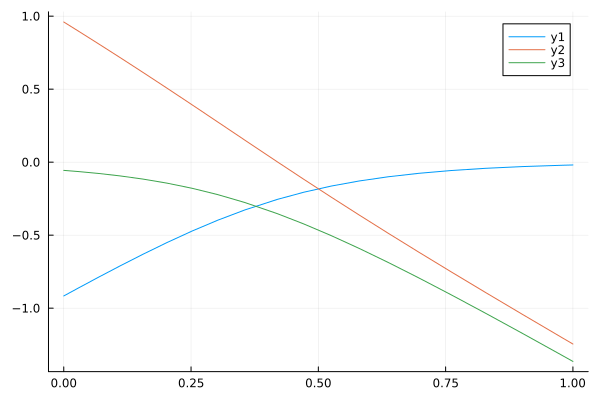

In [4]:
plot(x_traj)

In [5]:
typeof(model._Lt_sparse) |> fieldnames

(:m, :n, :colptr, :rowval, :nzval)

In [6]:
L = [1 0 1 1
    0 1 1 1]

2×4 Matrix{Int64}:
 1  0  1  1
 0  1  1  1

In [9]:
_create_vertex(model,[1,2])

Vertex([1, 2], 1, [1 0 0; 0 1 0], Num[0, 0], [1 0 0; 0 1 0; 1 1 -1], Num[0, 0, 0.0], [1 0 -1; 0 1 -1], Num[0, 0], LU{Float64, Matrix{Float64}, Vector{Int64}}([1.0 0.0 0.0; 0.0 1.0 0.0; 1.0 1.0 -1.0], [1, 2, 3], 0), 0, Matrix{Float64}(undef, 0, 0), Num[], Matrix{Float64}(undef, 0, 0), Num[], Int64[], Int64[], Int64[])

In [18]:
a = model._LNt_sparse
inv(Array(a))

3×3 Matrix{Float64}:
  0.666667  -0.333333   0.333333
 -0.333333   0.666667   0.333333
  0.333333   0.333333  -0.333333

In [26]:
L = L_generator(10,20) #|> pythonprint

10×20 Matrix{Int64}:
 1  0  0  0  0  0  0  0  0  0  1  0  1  1  0  0  0  1  2  2
 0  1  0  0  0  0  0  0  0  0  1  0  1  1  0  0  0  1  1  1
 0  0  1  0  0  0  0  0  0  0  1  1  1  1  1  1  0  2  2  3
 0  0  0  1  0  0  0  0  0  0  1  0  1  1  0  0  0  1  1  1
 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  1  0  0  1  0  1  1  1
 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  1  0  0  1  1  1  2  1  1  0  2  2  3
 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  0  0  1  1  0  1  1  0  0  0  1  1  1

In [29]:
L |> pythonprint

[[1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,2,2],[0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,1,1],[0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,0,2,2,3],[0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,1,1],[0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,1,1],[0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0],[0,0,0,0,0,0,0,1,0,0,1,1,1,2,1,1,0,2,2,3],[0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0],[0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,1,1,1]]


true

In [46]:
adjoint(sparse([1, 3, 4, 2, 3, 4], [1, 1, 1, 2, 2, 2], [1.0, 1.0, 100.0, 1.0, 1.0, 1.0], 4, 2))

2×4 Adjoint{Float64, SparseMatrixCSC{Float64, Int64}} with 6 stored entries:
 1.0   ⋅   1.0  100.0
  ⋅   1.0  1.0    1.0

In [47]:
model._L_sparse_val_one

2×4 SparseMatrixCSC{Int64, Int64} with 6 stored entries:
 1  ⋅  1  1
 ⋅  1  1  1

In [37]:
jd = [v == [4,3] for v in vtx]
x_sample[:,jd]
# [get(model.verices_idx[v] for v in vtx]

4×6103 Matrix{Float64}:
     3.40864e-5      0.000411298  …   0.587413    29.001  0.166916
    19.2076         79.6328           0.120619  1727.45   1.3358e-5
 10634.6         77550.9             96.7025    3633.27   0.0221747
  8882.41        24598.0              1.16818    950.521  0.00904539

In [38]:
xx = x_sample[:,jd][:,1]

4-element Vector{Float64}:
     3.408643849917691e-5
    19.20761157202161
 10634.589690121991
  8882.410370647485

In [41]:
model.L * xx

2-element Vector{Float64}:
 898875.626788957
  19536.207672341498

In [42]:
model2 = Bnc(L = L = [1 0 1 1
    0 1 1 1])

Bnc([1 1 -1 0; 1 1 0 -1], [1 0 1 1; 0 1 1 1], 2, 4, 2, Num[x₁, x₂, x₃, x₄], Num[q₁, q₂], Num[K₁, K₂], nothing, Vector{Int64}[], Matrix{Int64}(undef, 0, 0), Matrix{Int64}(undef, 0, 0), Dict{Vector{Int64}, Any}(), 1, [0.0, 0.0, 0.0, 0.0], [0.47712125471966244, 0.47712125471966244, 0.0, 0.0], false, Dict{Vector{Int64}, Int64}(), sparse([1, 3, 4, 2, 3, 4], [1, 1, 1, 2, 2, 2], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 4, 2), sparse([1, 3, 4, 2, 3, 4, 1, 2, 3, 1, 2, 4], [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0], 4, 4), SparseArrays.UMFPACK.UmfpackLU{Float64, Int64}(SparseArrays.UMFPACK.Symbolic{Float64, Int64}(Ptr{Nothing} @0x000000001b3c6610), SparseArrays.UMFPACK.Numeric{Float64, Int64}(Ptr{Nothing} @0x00000000226b8ec0), 4, 4, [0, 3, 6, 9, 12], [0, 2, 3, 1, 2, 3, 0, 1, 2, 0, 1, 3], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0], 0, SparseArrays.UMFPACK.UmfpackWS{Int64}([130128955720096, 130129105815232, 130129106006736, 13012

In [43]:
get_vertex_x(model2, xx,; asymtotic=true)

2-element Vector{Int64}:
 3
 3

In [5]:
vtx = get_vertex_x(model,x_sample')

10000-element Vector{Vector{Int64}}:
 [3, 3]
 [3, 3]
 [3, 2]
 [4, 4]
 [1, 2]
 [4, 4]
 [3, 3]
 [4, 4]
 [4, 4]
 [1, 2]
 [3, 3]
 [4, 2]
 [4, 4]
 ⋮
 [4, 2]
 [3, 3]
 [3, 3]
 [1, 3]
 [4, 4]
 [4, 4]
 [1, 3]
 [4, 2]
 [1, 2]
 [4, 4]
 [4, 4]
 [4, 4]

In [37]:
classification_to_colors(model.vertex_idxvtx)

LoadError: MethodError: no method matching classification_to_colors(::Vector{Vector{Int64}})
The function `classification_to_colors` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  classification_to_colors([91m::Vector{Int64}[39m, [91m::String[39m)
[0m[90m   @[39m [35mMain[39m [90m/mnt/d/Realizibility-index/bnc_julia/[39m[90m[4mbnc_helperfunctions.jl:385[24m[39m
[0m  classification_to_colors([91m::Vector{Int64}[39m)
[0m[90m   @[39m [35mMain[39m [90m/mnt/d/Realizibility-index/bnc_julia/[39m[90m[4mbnc_helperfunctions.jl:385[24m[39m


In [48]:
L_from_N([1 1  0 0 0  -1 
        0 0  1 1 -1 0 ])

4×6 Matrix{Int64}:
 1  0  0  0  0  1
 0  1  0  0  0  1
 0  0  1  0  1  0
 0  0  0  1  1  0

In [44]:
L = [1  0 0  0 0 1
    0  1 0  0 0 1
    0  0 1  0 1 0
    0  0 0  1 1 0]

4×6 Matrix{Int64}:
 1  0  0  0  0  1
 0  1  0  0  0  1
 0  0  1  0  1  0
 0  0  0  1  1  0

In [45]:
N = N_from_L(L)

2×6 Matrix{Int64}:
 0  0  1  1  -1   0
 1  1  0  0   0  -1

In [46]:
L_from_N(N)

4×6 Matrix{Int64}:
 1  0  0  0  0  1
 0  1  0  0  0  1
 0  0  1  0  1  0
 0  0  0  1  1  0

In [46]:
@btime x_ineq_mtx(model,regime=[1,2],check=false)

  52.098 ns (8 allocations: 384 bytes)


([-1 0 1; 0 -1 1], Rational{Int64}[1, 1])

In [24]:
setdiff([2,3],2)

1-element Vector{Int64}:
 3

In [51]:
@btime x_ineq_mtx(model,regime=[1,2],check=false)

  51.847 ns (8 allocations: 384 bytes)


([-1 0 1; 0 -1 1], Rational{Int64}[1, 1])

In [48]:
for i in zip([1,2],[1,2,3])
    print(i)
end

(1, 1)(2, 2)

In [116]:
get_regime(model,exp10.(x_traj[2]))

20-element Vector{Vector{Int64}}:
 [3, 2]
 [3, 2]
 [3, 2]
 [3, 2]
 [3, 2]
 [3, 2]
 [3, 2]
 [3, 2]
 [3, 2]
 [1, 2]
 [1, 2]
 [1, 2]
 [1, 2]
 [1, 2]
 [1, 2]
 [1, 2]
 [1, 2]
 [1, 2]
 [1, 2]
 [1, 2]

In [19]:
_idx_val2Mtx([1,2,3],2,3)

3×3 Matrix{Int64}:
 2  0  0
 0  2  0
 0  0  2

In [76]:
fieldnames(typeof(model._Lt_sparse))

(:m, :n, :colptr, :rowval, :nzval)

In [99]:
model._Lt_sparse |> find_max_indices_per_column

2-element Vector{Int64}:
 1
 2

In [81]:
@btime a = model._Lt_sparse.n

  37.573 ns (2 allocations: 96 bytes)


2

In [82]:
@btime a = size(model._Lt_sparse,2)

  23.309 ns (1 allocation: 48 bytes)


2

In [61]:
sparse([1, 2], [1, 2], [1, 1], 2, 3)

2×3 SparseMatrixCSC{Int64, Int64} with 2 stored entries:
 1  ⋅  ⋅
 ⋅  1  ⋅

In [69]:
@btime get_reaction_order(model,x_traj[2],x_idx=[1,],only_q=true)

  24.037 μs (594 allocations: 222.77 KiB)


15×1×2 Array{Float64, 3}:
[:, :, 1] =
   0.8047713448959534
   0.7456234441041322
   0.6239497334007981
   0.4361964090868971
   0.12996745702748247
  -0.39148919315591973
  -1.4244540249331503
  -4.296132500977717
 -50.264400718839774
   9.926846476550974
   5.618510135026738
   4.222944661384322
   3.559272500134333
   3.1612663759257527
   2.9532223166926266

[:, :, 2] =
 -0.41688609630377516
 -0.4235808551022046
 -0.40096422554975736
 -0.3125648850941142
 -0.10221623333658326
  0.3312344661238329
  1.2729312622290572
  3.9909333400411886
 47.945544015086085
 -9.635107931619844
 -5.514556888284332
 -4.176781437762548
 -3.5372385409227167
 -3.150920514158873
 -2.947552694354432

In [53]:
@btime stack([∂logx_∂logqK(model, x=x_traj[2][i,:]) for i in 1:size(x_traj[2],1)], dims=1)

  10.585 μs (278 allocations: 36.62 KiB)


15×3×3 Array{Float64, 3}:
[:, :, 1] =
   0.804771   0.376876  1.18165
   0.745623   0.447775  1.1934
   0.62395    0.585181  1.20913
   0.436196   0.78681   1.22301
   0.129967   1.10624   1.23621
  -0.391489   1.64461   1.25313
  -1.42445    2.71305   1.28859
  -4.29613    5.70114   1.40501
 -50.2644    53.7438    3.47937
   9.92685   -9.19714   0.729707
   5.61851   -4.70557   0.912938
   4.22294   -3.25857   0.964379
   3.55927   -2.57521   0.984058
   3.16127   -2.16836   0.992904
   2.95322   -1.95698   0.996243

[:, :, 2] =
 -0.416886    0.804771   0.387885
 -0.423581    0.745623   0.322043
 -0.400964    0.62395    0.222986
 -0.312565    0.436196   0.123632
 -0.102216    0.129967   0.0277512
  0.331234   -0.391489  -0.0602547
  1.27293    -1.42445   -0.151523
  3.99093    -4.29613   -0.305199
 47.9455    -50.2644    -2.31886
 -9.63511     9.92685    0.291739
 -5.51456     5.61851    0.103953
 -4.17678     4.22294    0.0461632
 -3.53724     3.55927    0.022034
 -3.15092     3.1612

In [55]:
sol = qK_traj_cat(model, [1,10],(0,100), K = [1], only_q=true)

([0.0, 0.07790317983082622, 0.6678858940167718, 4.4215030559186985, 15.440423385133771, 30.95027556216329, 51.58683290509581, 69.06747672796016, 88.22869466041058, 100.0], [0.9999999997971286 9.999999997304899; 0.9999999997971286 9.99125715323434; … ; 0.9999999997942816 2.8957417610407576; 0.9999999997942648 2.366414568392266])

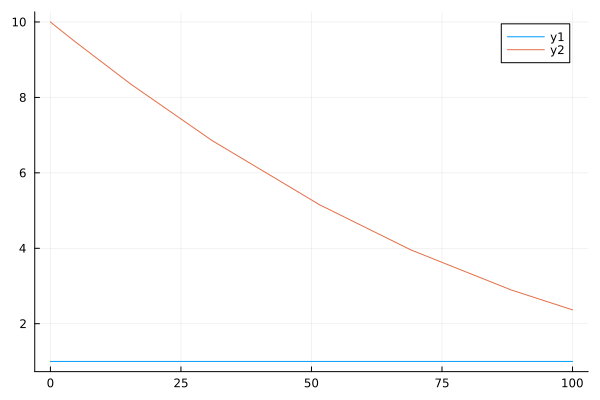

In [47]:
plot(sol)

In [36]:

typeof(sol[2]') <: AbstractArray{<:Real} # check if it is a 1D array

true

In [38]:
x2qK(model,sol[2]')

3×10 Matrix{Float64}:
  1.0   1.0       1.0       1.0      …   1.0       1.0       1.0
 10.0   9.99126   9.92518   9.51019      3.95456   2.89574   2.36641
 10.0  10.0      10.0      10.0         10.0      10.0      10.0

In [11]:
BLAS.get_num_threads()

24

In [10]:
BLAS.set_num_threads(24)

In [2]:
model2 = Bnc(N=N_generator(20,40))
nlu = copy(model2._LNt_lu)

SparseArrays.UMFPACK.UmfpackLU{Float64, Int64}
L factor:
40×40 SparseMatrixCSC{Float64, Int64} with 136 stored entries:
⎡⠓⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⣀⠳⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⠀⠉⢱⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠃⠘⠓⣄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠱⢄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠁⠘⢓⣄⠀⠀⠀⠀⎥
⎢⢔⠀⠀⠀⠀⠀⠀⠒⠂⠀⠒⠀⢀⡀⠀⢌⣵⣄⠀⠀⎥
⎣⠀⠉⠉⠉⠈⠉⠀⠈⠁⠛⠛⠀⠁⠡⠩⠀⣿⣿⣷⣄⎦
U factor:
40×40 SparseMatrixCSC{Float64, Int64} with 147 stored entries:
⎡⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠛⡄⠐⎤
⎢⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⎥
⎢⠀⠀⠀⠀⠙⢧⠀⢀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡆⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠙⢤⡆⠀⠄⠀⠀⠀⠀⠀⢰⠀⡀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠑⢶⡁⠀⠀⠀⠀⠀⠈⠀⣵⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢤⡄⠀⡀⠀⠘⠀⠛⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢆⢁⠀⠀⠰⠅⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢄⡇⣼⣣⣂⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢿⣿⣽⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⎦

In [3]:
z = zeros(40,40,40)
@btime z[1,:,:] .= nlu\rand(40,40)

  15.280 μs (17 allocations: 38.01 KiB)


40×40 view(::Array{Float64, 3}, 1, :, :) with eltype Float64:
  0.0417127   -0.0307396   0.0714984   …   0.122717    0.234915     0.211836
  0.0891929   -0.315605   -0.348159        0.457996   -0.437445    -0.0493427
 -0.00462019   0.188182    0.0244756       0.320579    0.29053      0.163109
  0.149881    -0.265664    0.127694       -0.386076    0.452094     0.158288
 -0.386099     0.138626    0.0854986       0.223113   -0.00120896   0.0420809
  0.115115     0.14086     0.0808811   …   0.0366273  -0.0928693    0.210859
 -0.109223     0.212393    0.0684433      -0.163598    0.0525051   -0.0197752
  0.392428     0.173098    0.459621        0.26454     0.349327     0.0746033
  0.0504748    0.320909    0.333814        0.0526043   0.0600497    0.408025
 -0.289543     0.201263    0.160499        0.176908   -0.0417503   -0.0159131
  0.0697279    0.17524     0.0315179   …  -0.398876   -0.435227    -0.12594
 -0.310016     0.340887   -0.512544       -0.415256   -0.101357    -0.043753
  0.35783 

In [4]:
@btime z[:,:,1] .= nlu\rand(40,40)

  14.571 μs (16 allocations: 37.96 KiB)


40×40 view(::Array{Float64, 3}, :, :, 1) with eltype Float64:
  0.395725     0.424389     0.0531229  …   0.0484437   0.0377731   0.367101
 -0.0689543    0.281528    -0.37292        0.0842335   0.386213    0.273551
 -0.0256083    0.112614     0.295752       0.246171    0.0988686  -0.18012
  0.179343     0.312979    -0.0972151     -0.158703   -0.0788242   0.153879
 -0.0997958    0.172775    -0.245179      -0.0111424  -0.0794498   0.00212774
 -0.00324437  -0.146428     0.124437   …   0.0986775   0.129782    0.284621
  0.181083    -0.177391     0.432449       0.101883    0.182298   -0.025121
 -0.0436035   -0.191833     0.393396       0.332001    0.366754    0.0226949
  0.432858    -0.201683    -0.0734553      0.275109    0.0289084   0.184174
  0.134695    -0.183545    -0.0625705     -0.184349    0.175702   -0.0760975
 -0.160809     0.0627869   -0.232843   …  -0.0354184   0.290484   -0.318451
  0.278612    -0.400301    -0.180393      -0.325637   -0.480399   -0.32401
  0.0285824    0.507989 

In [5]:
@btime ldiv!(@view(z[:,:,1]), nlu, rand(40,40))

  12.478 μs (7 allocations: 12.74 KiB)


40×40 view(::Array{Float64, 3}, :, :, 1) with eltype Float64:
  0.0191538   0.256597      0.140869   …   0.0974503   0.34316     0.0690812
 -0.448079    0.176383      0.177985       0.0613426  -0.353274   -0.227512
  0.06421     0.0545376     0.473494       0.152582    0.130279    0.0489562
 -0.458963    0.244187     -0.165844      -0.496929    0.40386     0.0845591
  0.354186    0.143615      0.114521      -0.0791875   0.210215    0.0785866
  0.390379    0.22925       0.0327694  …   0.129102    0.0189731   0.132353
  0.0746533   0.131523      0.187559       0.224574    0.392604    0.372828
  0.428914    0.0244916     0.0558593      0.410074   -0.128732    0.0168183
  0.401426    0.139775      0.0951217      0.208285    0.413722    0.226739
 -0.320855    0.283711     -0.139264      -0.105464   -0.111543   -0.111533
  0.335408    0.114275     -0.297359   …   0.353589   -0.211821    0.427888
  0.143308   -0.61964      -0.258492      -0.137829    0.267952   -0.117606
  0.258688   -0.00075

In [93]:
@btime begin
    z = zeros(model2.n,model2.n)
    ldiv!(z, nlu, Matrix(I(model2.n)))
end

  12.832 μs (11 allocations: 26.92 KiB)


40×40 Matrix{Float64}:
  1.0   0.0   0.0          0.0          …   0.0           0.0
  0.0   1.0   0.0          0.0              0.0           0.0
  0.0   0.0   0.603266     0.00421582      -0.0815537     0.00595126
  0.0   0.0   0.00421582   0.353093         0.000582868   0.0139566
  0.0   0.0  -0.108649     0.0120646        0.307824     -0.0239086
  0.0   0.0  -0.00210791  -0.176546     …  -0.000291434  -0.00697828
  0.0   0.0   0.0          0.0              0.0           0.0
  0.0   0.0   0.00137144  -0.0688081       -0.0183879     0.304333
  0.0   0.0   0.0          0.0              0.0           0.0
  0.0   0.0  -0.0978822   -0.0204963       -0.144717      0.012006
  0.0   0.0  -0.0150239    0.0143859    …  -0.0428515     0.000333728
  0.0   0.0  -0.00645499  -0.114717        -0.00278474   -0.0223605
  0.0   0.0   0.00457982   0.0827647        0.0601502     0.117766
  ⋮                                     ⋱                
 -0.0  -0.0   0.019365     0.34415          0.00835422    

In [68]:
@btime rand(10) .+ rand(10)


  83.552 ns (6 allocations: 432 bytes)


10-element Vector{Float64}:
 0.9848368898070671
 1.506728957438238
 0.18297441197474773
 0.3287458927951197
 1.5727312441110386
 1.5940995575997206
 0.8636661918277744
 0.8178501782064984
 1.0078008415583803
 0.81531300406438

In [79]:
for i in 1:10
    rand(10000,10000) .* rand(10000,10000)
end

In [66]:
import Pkg; Pkg.add("Polyester")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `/mnt/d/Non-implementary-index/bnc_julia/Project.toml`
  [f517fe37] + Polyester v0.7.18
  No Changes to `/mnt/d/Non-implementary-index/bnc_julia/Manifest.toml`


In [67]:
using Polyester

In [ ]:
t = 0.0:0.1:400
sol = catalysis_logx(bnc_test,qK2x(bnc_test, [100,1000,1];output_logspace=true), (t[1], t[end]))

retcode: Success
Interpolation: 3rd order Hermite
t: 52-element Vector{Float64}:
   0.0
   0.08574408432686294
   0.7019095916859328
   4.362826346802653
  14.055617755791378
  25.685004906562888
  37.127819887486694
  48.517712357106
  58.778747855933204
  66.47632012583709
  72.22106417073695
  76.49258980972184
  79.6627002629106
   ⋮
 136.54837931632747
 143.89539989575738
 153.1017779345753
 163.72142759351405
 175.7509156481193
 189.94613233690004
 206.78729735400714
 227.3530436322011
 253.17781154466522
 287.13260251924066
 334.80538852764755
 400.0
u: 52-element Vector{Vector{Float64}}:
 [-2.1984582309131464, 6.802518059392708, 4.604059828479591]
 [-2.197507415188501, 6.801566186833489, 4.604058771645018]
 [-2.190648074353429, 6.794699191940921, 4.604051117587521]
 [-2.1488952772104875, 6.752898653565413, 4.604003376354954]
 [-2.0291278095704213, 6.63298262957718, 4.603854820006786]
 [-1.8635226295741287, 6.467140358884179, 4.603617729310077]
 [-1.6685388047778527, 6.271821988

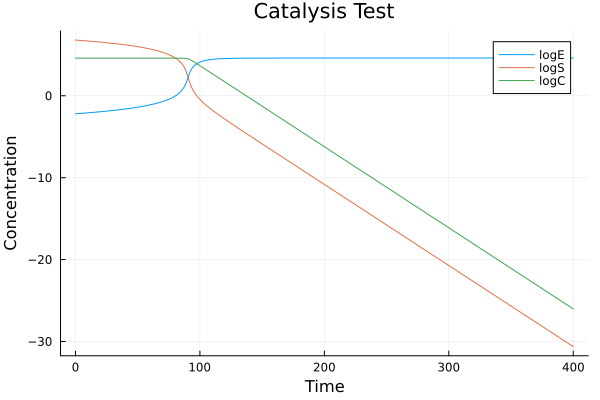

In [ ]:
logx = sol.(t)|> (x -> stack(x,dims=1))
x = exp.(logx)
logqK = eachrow(logx) .|> (x->x2qK(bnc_test,x,input_logspace=true, output_logspace=true)) |> (x -> stack(x,dims=1))  # convert sol to qK
qK = exp.(logqK) # convert logqK to qK
# # "log" .* string.([bnc_test.q_sym; bnc_test.K_sym]')
# # label=[bnc_test.q_sym; bnc_test.K_sym]'
# plot(t,logqK, xlabel="Time", ylabel="Concentration", title="Catalysis Test",label="log" .* string.([bnc_test.q_sym; bnc_test.K_sym]'), legend=:topright)
plot(t,logx, xlabel="Time", ylabel="Concentration", title="Catalysis Test",label="log" .* string.([bnc_test.x_sym;]'), legend=:topright)

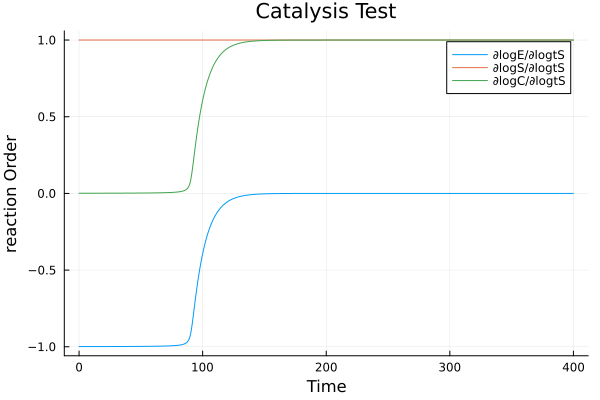

In [ ]:
logtS = logx[:,2]
δlogx = logx[2:end,:] .- logx[1:end-1,:]
δlogtS = logtS[2:end] .- logtS[1:end-1]

∂logx_∂logtS = δlogx ./ δlogtS
t2 = t[2:end] .- (t[2]-t[1])/2 # shift time to the middle of the interval

label = "∂log" .* string.(bnc_test.x_sym) .* "/∂logtS"
plot(t2, ∂logx_∂logtS, xlabel="Time", ylabel="reaction Order", title="Catalysis Test", label=hcat(label...), legend=:topright)

In [ ]:
find_valid_regime(bnc_test)

4-element Vector{Vector{Int64}}:
 [1, 2]
 [1, 3]
 [3, 2]
 [3, 3]

In [ ]:
valid_regime = []
logder_x_ts_regime = []
for regime in find_valid_regime(bnc_test)
    M,singularity =  ∂logx_∂logqK_regime(bnc_test,regime=regime)
    if singularity == 0
        logder_x_ts = M[:,2]
        push!(logder_x_ts_regime, logder_x_ts)
        push!(valid_regime, regime)
    end
end

In [ ]:
valid_regime

3-element Vector{Any}:
 [1, 2]
 [1, 3]
 [3, 2]

In [ ]:
logder_x_ts_regime

3-element Vector{Any}:
 [-0.0, 1.0, 1.0]
 [-0.0, 1.0, 1.0]
 [-1.0, 1.0, 0.0]

In [ ]:
x = 
plot(sol, xlabel="Time", ylabel="Concentration", title="Catalysis Test",label=[bnc_test.q_sym; bnc_test.K_sym]', legend=:topright)

1×3 adjoint(::Vector{Num}) with eltype Num:
 tE  tS  K

In [ ]:
"log" .* string.([bnc_test.q_sym; bnc_test.K_sym]')

1×3 Matrix{String}:
 "logtE"  "logtS"  "logK"

In [ ]:
["tE" "tS" "K"]

1×3 Matrix{String}:
 "tE"  "tS"  "K"

In [ ]:
sol(1)

3-element Vector{Float64}:
 0.10400591806729628
 6.792591270023021
 4.594012095096241

In [ ]:
    #case1-------------
# #binding
N = [1 0 -1 0
    0 1 1 -1]
# L = [
# 	1 0 1
# 	0 1 1
# 	]
x_sym = [:P, :P2, :DNA, :C]
q_sym = [:tP, :tD]
K_sym = [:K1, :K2]

#Catalysis
S = Matrix([-1 0  # R1: tP's degrdation caused by P
    -1 0   # R2: tP's degradation Caused by P2 
     1 0]') # R3: tP's synthesis

aT = [1 0 0 0 # P cause R1 
      0 1 0 0 # P2 cause R2
      0 0 0 1] # C cause R3

k = [0.1, 0.1, 1 ] #catalysis rate

bnc_test = Bnc(N=N,
    # L=L,
    x_sym=x_sym, q_sym=q_sym, K_sym=K_sym,
    S=S, aT=aT, k=k)

sol = catalysis_logx(bnc_test,ones(bnc_test.n), (0.0, 10.0))

retcode: Success
Interpolation: 3rd order Hermite
t: 12-element Vector{Float64}:
  0.0
  0.04949422525756363
  0.31468966589877334
  1.034240721579605
  1.9278840093736045
  2.928834962987815
  4.218039231063516
  5.4090162126185595
  6.767159022844265
  8.198028486211149
  9.741445643062843
 10.0
u: 12-element Vector{Vector{Float64}}:
 [1.0, 1.0, 1.0, 1.0]
 [1.0056558545607892, 0.9943281511790766, 1.0113117091215786, 1.005639860300655]
 [1.035926813561559, 0.9634279572576009, 1.0718536271231183, 1.035281584380719]
 [1.1174353673670594, 0.875684891290688, 1.2348707347341192, 1.1105556260248073]
 [1.2162114499856225, 0.7605947259026697, 1.4324228999712458, 1.1930176258739156]
 [1.3217893320921603, 0.6273060806110993, 1.6435786641843213, 1.2708847447954206]
 [1.447577029463345, 0.4554361106689698, 1.8951540589266906, 1.3505901695956604]
 [1.5525082517610878, 0.30204581732669616, 2.1050165035221764, 1.4070623208488726]
 [1.6591633877717538, 0.13770874082025522, 2.3183267755435084, 1.45603

In [ ]:
ones(3,3) .*= 10

3×3 Matrix{Float64}:
 10.0  10.0  10.0
 10.0  10.0  10.0
 10.0  10.0  10.0

In [ ]:
bnc_test._LNt_sparse.nzval

10-element Vector{Float64}:
  1.0
  2.0
  2.0
  1.0
  1.0
  2.0
 -1.0
  1.0
  1.0
 -1.0

In [ ]:
x_sym = [:P1, :D1, :P2, :D2, :P3, :D3, :C1, :C2, :C3]

N = [1 1 0 0 0 0 -1 0 0 
     0 0 1 1 0 0 0 -1 0
     0 0 0 0 1 1 0 0 -1
    ]

q_sym = [:tP1, :tD1, :tP2, :tD2, :tP3, :tD3]

S = Matrix([-1 0 0 0 0 0  
             0 0 -1 0 0 0
             0 0 0 0 -1 0
             -1 0 0 0 0 0  
             0 0 -1 0 0 0
             0 0 0 0 -1 0
             1 0 0 0 0 0 
             0 0 1 0 0 0  
             0 0 0 0 1 0 ]')  

K_sym = [:K1, :K2, :K3]

#Catalysis
            # :tP1, :tP2, :tP3, :tD1, :tD2, :tD3


aT = [  1 0 0 0 0 0 0 0 0 
        0 0 1 0 0 0 0 0 0 
        0 0 0 0 1 0 0 0 0
        0 0 0 0 0 0 1 0 0 
        0 0 0 0 0 0 0 1 0 
        0 0 0 0 0 0 0 0 1
 
        0 0 0 0 0 1 0 0 0 
        0 1 0 0 0 0 0 0 0 
        0 0 0 1 0 0 0 0 0]

degrate = 0.02
birthrate = 1.0
k = [repeat([degrate],6); repeat([birthrate],3) ] #catalysis rate

bnc_test = Bnc(N=N,
    # L=L,
    x_sym=x_sym, q_sym=q_sym, K_sym=K_sym,
    S=S, aT=aT, k=k)

Bnc([1 1 … 0 0; 0 0 … -1 0; 0 0 … 0 -1], [1 0 … 0 0; 0 1 … 0 0; … ; 0 0 … 0 1; 0 0 … 0 1], 3, 9, 6, Num[P1, D1, P2, D2, P3, D3, C1, C2, C3], Num[tP1, tD1, tP2, tD2, tP3, tD3], Num[K1, K2, K3], -1, [-1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], [1 0 … 0 0; 0 0 … 0 0; … ; 0 1 … 0 0; 0 0 … 0 0], [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 1.0, 1.0, 1.0], 9, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.0, 0.0, 0.0], true, sparse([1, 7, 2, 7, 3, 8, 4, 8, 5, 9, 6, 9], [1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 9, 6), sparse([1, 7, 2, 7, 3, 8, 4, 8, 5, 9  …  9, 1, 2, 7, 3, 4, 8, 5, 6, 9], [1, 1, 2, 2, 3, 3, 4, 4, 5, 5  …  6, 7, 7, 7, 8, 8, 8, 9, 9, 9], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0], 9, 9), SparseArrays.UMFPACK.UmfpackLU{Float64, Int64}(Spars

In [ ]:
K

3-element Vector{Float64}:
 3.932371449041635e-8
 3.0747344694834737e-6
 1.874722247475269e-6

In [ ]:
reduce(hcat, @."log" * string(bnc_test.x_sym))


1×9 Matrix{String}:
 "logP1"  "logD1"  "logP2"  "logD2"  …  "logD3"  "logC1"  "logC2"  "logC3"

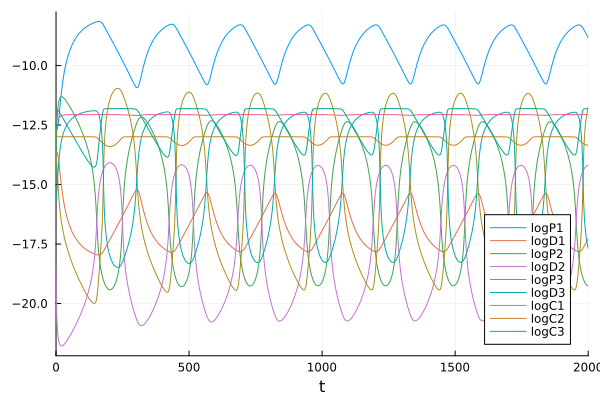

In [ ]:
t = 0.0:0.1:2000
tP = randomize(3,-7,-5)
tD = randomize(3,-6,-5)
K = randomize(3,-9,-5)
degrate = 0.02
birthrate = 1
bnc_test.k = [repeat([degrate],6); repeat([birthrate],3) ]
sol = catalysis_logx(bnc_test,qK2x(bnc_test, [reduce(hcat,hcat.(tP,tD))[:]; K];output_logspace=true), (t[1], t[end]))
plot(sol,label= reduce(hcat, @."log" * string(bnc_test.x_sym)))

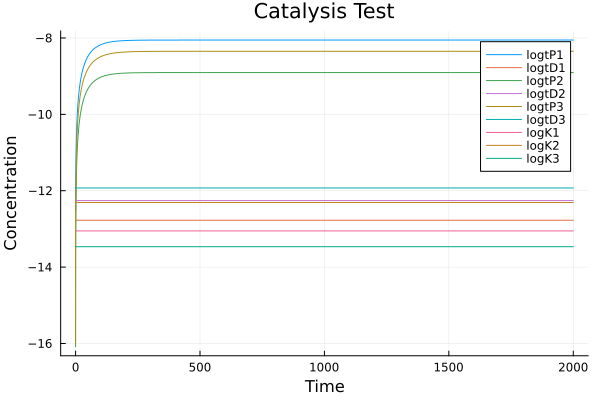

In [ ]:
logx = sol.(t)|> (x -> stack(x,dims=1))
x = exp.(logx)
logqK = eachrow(logx) .|> (x->x2qK(bnc_test,x,input_logspace=true, output_logspace=true)) |> (x -> stack(x,dims=1))  # convert sol to qK
qK = exp.(logqK) # convert logqK to qK
# # "log" .* string.([bnc_test.q_sym; bnc_test.K_sym]')
# # label=[bnc_test.q_sym; bnc_test.K_sym]'
plot(t,logqK, xlabel="Time", ylabel="Concentration", title="Catalysis Test",label="log" .* string.([bnc_test.q_sym; bnc_test.K_sym]'), legend=:topright)
# plot(t,logx, xlabel="Time", ylabel="Concentration", title="Catalysis Test",label="log" .* string.([bnc_test.x_sym;]'), legend=:topright)

In [ ]:
exp.(logqK[end,:])

9-element Vector{Float64}:
 23.570306040232698
  1.0000000174172434
  6.0246874463436475
  1.0000000167043177
  0.24527246890453602
  1.0000000217006357
  0.009999999999999915
  0.010000000000000085
  0.010000000000000564

In [ ]:
@btime qK2x(bnc_test, ones(400))

  111.440 ms (18420 allocations: 130.54 MiB)


400-element Vector{Float64}:
 1.0000002606615026
 0.25966330465079746
 0.7812584523134346
 1.0000002606615026
 1.0000002606615026
 0.371409081533111
 0.8850824201558444
 0.45856552692955027
 0.618034177391309
 0.5620162619169674
 0.5552151854999765
 0.4039477228207865
 0.9521392685692572
 ⋮
 0.019371466159207096
 0.38196608336785676
 0.10324221611964467
 0.0003409565428819548
 0.31845527588193384
 0.31643973046225576
 0.28621264399772656
 0.13318817608252337
 0.21723804485139606
 0.007798962872959353
 0.056615974553530964
 0.0413151166157001

In [ ]:
all(bnc_test._Lt_sparse.nzval .== 1)

false

In [ ]:
L =  [1 0 0 1 1 1
    0 1 0 1 0 1
    0 0 1 0 1 1]

bnc_test= Bnc(L=L)

Bnc([1 1 … 0 0; 1 0 … -1 0; 1 1 … 0 -1], [1 0 … 1 1; 0 1 … 0 1; 0 0 … 1 1], 3, 6, 3, Num[x₁, x₂, x₃, x₄, x₅, x₆], Num[q₁, q₂, q₃], Num[K₁, K₂, K₃], -1, nothing, nothing, nothing, nothing, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.3862943611198906, 1.0986122886681098, 1.0986122886681098, 0.0, 0.0, 0.0], true, sparse([1, 4, 5, 6, 2, 4, 6, 3, 5, 6], [1, 1, 1, 1, 2, 2, 2, 3, 3, 3], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 6, 3), sparse([1, 4, 5, 6, 2, 4, 6, 3, 5, 6, 1, 2, 4, 1, 3, 5, 1, 2, 3, 6], [1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0], 6, 6), SparseArrays.UMFPACK.UmfpackLU{Float64, Int64}(SparseArrays.UMFPACK.Symbolic{Float64, Int64}(Ptr{Nothing} @0x0000000037eec540), SparseArrays.UMFPACK.Numeric{Float64, Int64}(Ptr{Nothing} @0x000000003e3f1690), 6, 6, [0, 4, 7, 10, 13, 16, 20], [0, 3, 4, 5, 1, 3, 5, 2, 4, 5, 0, 1, 3, 0, 2, 4, 0, 1, 2, 5], [1.0, 1.0, 1.0, 1.0, 

In [ ]:
#|>svd |> (x->x.U)
rnd(x) = x .|> (x-> abs(x) > 1e-10 ? x : 0) |> (x-> round.(x,digits=2))

rnd (generic function with 1 method)

In [ ]:
c = create_regime(bnc_test; regime=[6,6,6])

┌ Warning: Multiple singular values found
└ @ Main /mnt/d/Non-implementary-index/bnc_julia/functions.jl:1189


Regime([6, 6, 6], [0 0 … 0 1; 0 0 … 0 1; … ; 1 0 … -1 0; 1 1 … 0 -1], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 2, -1, [1, 1, 1])

In [ ]:
x_ineq_mtx(bnc_test, regime=c.regime) * log.(bnc_test.x_sym) .<0 .|> simplify

5-element Vector{Num}:
 (-log(x₆) + log(x₅)) < 0
 (-log(x₆) + log(x₂)) < 0
  (log(x₁) - log(x₆)) < 0
 (-log(x₆) + log(x₃)) < 0
 (-log(x₆) + log(x₄)) < 0

In [ ]:
a = ∂logqK_∂logx_regime(bnc_test;regime=[6,6,6])

6×6 Matrix{Int64}:
 0  0  0   0   0   1
 0  0  0   0   0   1
 0  0  0   0   0   1
 1  1  0  -1   0   0
 1  0  1   0  -1   0
 1  1  1   0   0  -1

In [ ]:
a_svd = svd(a,full=true)
non_singular_idx = findall(a_svd.S .> 1e-10)
singular_idx = findall(a_svd.S .<= 1e-10)

2-element Vector{Int64}:
 5
 6

In [ ]:
#y = Ax, x = A^-1y 
a_svd.S[singular_idx] .= 0.0
S_inv = zeros(size(a_svd.S))
S_inv[non_singular_idx] = 1 ./ a_svd.S[non_singular_idx]
S_inv[singular_idx] .= randomize(length(singular_idx))

a_inv = a_svd.V * Diagonal(S_inv) * a_svd.U'

y = a * randomize(bnc_test.n) 

a*(a_inv*y) - y

6-element Vector{Float64}:
 -4.134373399189428e-12
 -4.134373399189428e-12
 -4.134373399189428e-12
  7.275957614183426e-12
  2.9103830456733704e-11
  7.275957614183426e-12

In [ ]:
Un = a_svd.U[:,singular_idx]

6×2 Matrix{Float64}:
  0.812278     -0.0828899
 -0.334354      0.744899
 -0.477924     -0.662009
  1.11022e-16  -9.02056e-17
  5.55112e-17  -4.85723e-17
  5.55112e-17   1.17961e-16

In [ ]:
Un' *x

2-element Vector{Float64}:
 -109.3207711357929
 -148.76669127594013

In [ ]:
∂logx_∂logqK_regime(bnc_test;regime=[5,6,6])[1]

6×6 Matrix{Int64}:
 0  -1   1  0  0  0
 0   0   0  0  0  0
 0   1  -1  0  0  0
 0  -1   1  0  0  0
 0   0   0  0  0  0
 0   0   0  0  0  0

In [ ]:
using SparseArrays

In [ ]:
a = sparse(Matrix{Float64}([bnc_test.L;bnc_test.N]))
at = sparse(Matrix{Float64}([bnc_test.L;bnc_test.N])')
x = randomize(bnc_test.n)
y = zeros(bnc_test.n)

4000-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [ ]:
a_lu = lu(a)
b = copy(a)
@btime let 
    """
    after modification to generate b
    """
    lu!(a_lu, b) # recalculate a_lu
    ldiv!(y, a_lu, x)
end


  4.366 ms (34 allocations: 5.10 MiB)


4000-element Vector{Float64}:
   1749.3608739866413
  16647.12382356418
  -2603.7085632983976
  -3053.019273515337
    306.90073229898405
    -57.3555460490403
  -9747.34401752881
  -2135.893001204731
 -11659.187330473125
  -2541.681864480493
   1649.0095821387874
  23481.832446176362
  -9747.345042006917
      ⋮
   1686.1884019598597
  -8225.312085448233
  -4861.7047950050655
  -1238.3777165895387
   -720.8010583655774
  -8793.514032442297
  -4598.267078377382
  -7575.789188751974
  11099.895522874922
   1449.2926229337836
   -574.853927610026
  -4298.758138270264

In [ ]:
#first way, transpose after lu.
at_lu = lu(at)
bt = copy(at)
@btime let 
    """
    after modification to generate b
    """
    lu!(at_lu, bt) # recalculate a_lu
    ldiv!(y, at_lu', x)
end

  4.434 ms (35 allocations: 4.80 MiB)


4000-element Vector{Float64}:
   1749.3608739866395
  16647.12382356422
  -2603.708563298392
  -3053.019273515364
    306.90073229896774
    -57.35554604906656
  -9747.344017528907
  -2135.8930012047695
 -11659.187330473167
  -2541.681864480512
   1649.0095821388009
  23481.832446176366
  -9747.345042007013
      ⋮
   1686.1884019598597
  -8225.312085448266
  -4861.704795005113
  -1238.3777165895817
   -720.801058365596
  -8793.514032442337
  -4598.26707837743
  -7575.7891887519945
  11099.895522874875
   1449.2926229337663
   -574.8539276100317
  -4298.758138270286

In [ ]:
test = [1 0 1;0 1 1;1 1 -1]

3×3 Matrix{Int64}:
 1  0   1
 0  1   1
 1  1  -1

In [ ]:
test= sparse(test')

3×3 SparseMatrixCSC{Int64, Int64} with 7 stored entries:
 1  ⋅   1
 ⋅  1   1
 1  1  -1

In [ ]:
V = findnz(test)

([1, 3, 2, 3, 1, 2, 3], [1, 1, 2, 2, 3, 3, 3], [1, 1, 1, 1, 1, 1, -1])

In [ ]:
test.rowval

7-element Vector{Int64}:
 1
 3
 2
 3
 1
 2
 3

In [ ]:
a = SparseArrays.sparse!(V...)

3×3 SparseMatrixCSC{Int64, Int64} with 7 stored entries:
 1  ⋅   1
 ⋅  1   1
 1  1  -1

In [ ]:
a.colptr

4-element Vector{Int64}:
 1
 3
 5
 8

In [ ]:
a

3×3 SparseMatrixCSC{Int64, Int64} with 7 stored entries:
 1  ⋅   1
 ⋅  1   1
 1  1  -1

In [ ]:
alu = lu(a)

SparseArrays.UMFPACK.UmfpackLU{Float64, Int64}
L factor:
3×3 SparseMatrixCSC{Float64, Int64} with 5 stored entries:
 1.0        ⋅         ⋅ 
  ⋅        1.0        ⋅ 
 0.666667  0.666667  1.0
U factor:
3×3 SparseMatrixCSC{Float64, Int64} with 5 stored entries:
 0.5   ⋅    0.5
  ⋅   0.5   0.5
  ⋅    ⋅   -1.0

In [ ]:
V

([1, 3, 5, 8], [1, 3, 2, 3, 1, 2, 3], [1, 1, 1, 1, 1, 1, -1])

In [ ]:
#second way, transpose before lu, no works
# a_lu = lu(at')
# bt = copy(at)
# @btime let 
#     """
#     after modification to generate b
#     """
#     lu!(a_lu, bt') # recalculate a_lu
#     ldiv!(y, at_lu, x)
# end

4000×4000 SparseMatrixCSC{Float64, Int64} with 21821 stored entries:
⎡⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣇⡶⣷⣧⡿⢿⡽⡾⡶⣽⣚⡲⣿⣾⠖⎤
⎢⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣺⡵⡿⣿⣾⠽⣝⢯⣪⣧⢩⣺⡽⢲⡯⣿⢇⎥
⎢⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣯⣽⣵⣿⣿⣺⣿⢿⣽⣾⢿⡻⡶⣜⢻⡽⣝⣷⡿⢛⎥
⎢⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣯⣿⣿⣿⢿⣯⣾⣦⣯⠿⣗⠻⣿⢇⣿⣱⢕⣇⡊⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⡟⣾⣯⢿⣴⣟⣿⣯⢝⡙⢝⣷⣾⣗⢻⣱⣕⣍⡗⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⣿⣽⣺⡧⢾⣏⣯⣿⣿⠿⡯⣯⣿⡵⣾⣶⣵⣿⣭⠳⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⣿⣻⣟⣯⣫⣿⣫⡿⣿⢷⣿⣿⠓⡿⣿⢽⢿⡾⠬⡺⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⡿⣿⣷⣿⣿⣿⢻⣿⣝⡿⣟⣿⢯⡻⣻⡿⣫⣻⣵⡟⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⡿⣿⣽⣟⡛⣷⡻⣵⠧⣷⣻⣻⣻⣷⣳⢺⣽⢧⣿⡞⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⣿⣿⣹⣾⣭⠽⣳⣯⡜⣿⣿⣸⣟⡿⣯⡯⡟⢽⢼⣅⎥
⎢⣿⣿⣿⣿⣏⣿⡿⣿⣿⠿⣟⣿⣿⣻⣿⣯⣿⣯⣿⣿⠙⢿⣽⣻⡿⣯⣯⢾⣮⣻⣯⣿⣿⣟⡳⣏⣵⣫⣷⣟⎥
⎢⣿⣿⣻⣿⣽⣿⣿⣿⣾⣿⢿⣿⣿⣽⣽⣿⣷⣿⣿⣾⠀⠀⠙⢿⣽⡟⡮⣿⣿⡞⣿⣯⡌⣿⡞⣿⣿⣓⣿⣇⎥
⎢⣿⣿⣷⣿⣿⣿⣿⣿⣟⣿⣿⣷⣿⣾⣿⣿⣿⣮⣷⣿⠀⠀⠀⠀⠙⢏⣟⣽⣟⢾⣽⢛⣽⣷⣸⣿⢲⣏⣿⣺⎥
⎢⣾⣿⣿⣿⣿⣟⣿⣿⣿⣿⣯⣿⣿⣿⣿⣿⣟⣾⣿⣿⠀⠀⠀⠀⠀⠀⠙⢟⣿⣿⣿⣫⣪⢽⣯⣞⣾⡾⡿⣷⎥
⎢⣽⣿⣿⣿⣻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣾⣯⠀⠀⠀⠀⠀⠀⠀⠀⠙⢟⡏⣿⣷⣻⢿⡬⣴⣻⠦⣇⎥
⎢⣿⣿⣯⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣻⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⠾⢷⡿⡾⣯⣵⠾⣳⎥
⎢⣾⣿⣿⣿⣿⣿⣿⣾⣿⣿⣿⣿⣿⣾⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢶⣯⡿⣇⢓⣵⡢⎥
⎢⣷⣿⣿⣿⣿⣷⣿⣿⣿⣿⣿⣿⣿⣟⣿⣿⣿⣟⣯⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢟⡾⣝⠘⢊⎥
⎢⣿⣿⣿⡿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣻⡓⎥
⎣⣿⣿⣿⣿⣿⣿⣿⣽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢷⎦

In [ ]:
at = sparse(Matrix{Float64}([bnc_test.L;bnc_test.N])')

4000×4000 SparseMatrixCSC{Float64, Int64} with 21821 stored entries:
⎡⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣇⡶⣷⣧⡿⢿⡽⡾⡶⣽⣚⡲⣿⣾⠖⎤
⎢⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣺⡵⡿⣿⣾⠽⣝⢯⣪⣧⢩⣺⡽⢲⡯⣿⢇⎥
⎢⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣯⣽⣵⣿⣿⣺⣿⢿⣽⣾⢿⡻⡶⣜⢻⡽⣝⣷⡿⢛⎥
⎢⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣯⣿⣿⣿⢿⣯⣾⣦⣯⠿⣗⠻⣿⢇⣿⣱⢕⣇⡊⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⡟⣾⣯⢿⣴⣟⣿⣯⢝⡙⢝⣷⣾⣗⢻⣱⣕⣍⡗⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⣿⣽⣺⡧⢾⣏⣯⣿⣿⠿⡯⣯⣿⡵⣾⣶⣵⣿⣭⠳⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⣿⣻⣟⣯⣫⣿⣫⡿⣿⢷⣿⣿⠓⡿⣿⢽⢿⡾⠬⡺⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⡿⣿⣷⣿⣿⣿⢻⣿⣝⡿⣟⣿⢯⡻⣻⡿⣫⣻⣵⡟⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⡿⣿⣽⣟⡛⣷⡻⣵⠧⣷⣻⣻⣻⣷⣳⢺⣽⢧⣿⡞⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⣿⣿⣹⣾⣭⠽⣳⣯⡜⣿⣿⣸⣟⡿⣯⡯⡟⢽⢼⣅⎥
⎢⣿⣿⣿⣿⣏⣿⡿⣿⣿⠿⣟⣿⣿⣻⣿⣯⣿⣯⣿⣿⠙⢿⣽⣻⡿⣯⣯⢾⣮⣻⣯⣿⣿⣟⡳⣏⣵⣫⣷⣟⎥
⎢⣿⣿⣻⣿⣽⣿⣿⣿⣾⣿⢿⣿⣿⣽⣽⣿⣷⣿⣿⣾⠀⠀⠙⢿⣽⡟⡮⣿⣿⡞⣿⣯⡌⣿⡞⣿⣿⣓⣿⣇⎥
⎢⣿⣿⣷⣿⣿⣿⣿⣿⣟⣿⣿⣷⣿⣾⣿⣿⣿⣮⣷⣿⠀⠀⠀⠀⠙⢏⣟⣽⣟⢾⣽⢛⣽⣷⣸⣿⢲⣏⣿⣺⎥
⎢⣾⣿⣿⣿⣿⣟⣿⣿⣿⣿⣯⣿⣿⣿⣿⣿⣟⣾⣿⣿⠀⠀⠀⠀⠀⠀⠙⢟⣿⣿⣿⣫⣪⢽⣯⣞⣾⡾⡿⣷⎥
⎢⣽⣿⣿⣿⣻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣾⣯⠀⠀⠀⠀⠀⠀⠀⠀⠙⢟⡏⣿⣷⣻⢿⡬⣴⣻⠦⣇⎥
⎢⣿⣿⣯⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣻⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⠾⢷⡿⡾⣯⣵⠾⣳⎥
⎢⣾⣿⣿⣿⣿⣿⣿⣾⣿⣿⣿⣿⣿⣾⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢶⣯⡿⣇⢓⣵⡢⎥
⎢⣷⣿⣿⣿⣿⣷⣿⣿⣿⣿⣿⣿⣿⣟⣿⣿⣿⣟⣯⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢟⡾⣝⠘⢊⎥
⎢⣿⣿⣿⡿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣻⡓⎥
⎣⣿⣿⣿⣿⣿⣿⣿⣽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢷⎦

In [ ]:
# a_int = Matrix{Float64}([bnc_test.L;bnc_test.N])

In [ ]:
L = sparse(Matrix{Float64}(bnc_test.L))
Lt = sparse(Matrix{Float64}(bnc_test.L)')

4000×2000 SparseMatrixCSC{Float64, Int64} with 13892 stored entries:
⎡⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⎥
⎢⣽⡯⣿⣟⣽⡯⢫⣿⣯⣋⣛⣿⡻⡻⢿⣯⣯⢿⣯⣟⣽⢟⣯⣝⡭⣻⎥
⎢⢿⣿⢿⢷⢷⢟⣽⣾⣷⣽⣪⣶⣦⣻⣿⣫⡎⠽⢪⣻⣹⣫⡿⣿⣬⢫⎥
⎢⢿⣿⣷⣼⣿⣻⣟⣿⣿⣭⢿⣵⣯⣹⣿⣻⣽⣿⡫⣿⣿⣯⣍⣿⣿⣗⎥
⎢⣿⣿⣷⣿⣏⣟⣽⣻⣿⣯⣻⣝⣱⣾⣿⣻⣝⣿⣿⣯⣽⣿⣶⣿⣾⣿⎥
⎢⡿⢟⣟⣻⣻⣿⣿⢽⣯⡷⢮⣿⣿⣭⣿⣿⣿⢽⡿⡻⣿⢿⣶⣽⣿⢾⎥
⎢⣛⣿⣷⢿⣾⡷⣿⣿⣿⣯⣾⢿⢾⣎⣿⢿⣞⣟⣾⣿⣿⣿⣿⣍⣟⢟⎥
⎢⣿⣯⣿⣿⣟⣵⣿⣟⣿⣿⣻⣿⣿⣿⣿⣝⢿⣻⣿⡿⣿⣻⣷⣻⣯⣯⎥
⎢⢿⣿⣿⣿⣿⣻⣿⢿⣿⡻⣿⣶⣿⣿⣷⣾⣿⡻⣿⣷⣾⣿⣽⡯⣿⡿⎥
⎢⣿⣷⣿⣟⣿⢽⣿⣭⣿⣪⣿⣿⣿⣿⡿⣿⣾⣯⣿⣿⣳⣿⣿⣟⣿⣯⎥
⎢⣯⣯⣿⣿⣿⣾⣻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡶⣿⣷⣯⣿⡿⣿⣻⡿⎥
⎢⣻⣿⣷⣿⣏⣿⣾⣽⣿⣿⣻⣿⢶⡿⣿⣿⣽⣫⡽⣟⣿⣿⣷⣷⣽⣏⎥
⎢⣿⣿⣿⣯⣟⣿⣿⡯⣿⣿⣻⣞⣷⣿⣿⣿⢿⣿⡿⣿⣿⣿⢿⣿⣾⢧⎥
⎣⣿⣿⣿⣿⣏⣾⣿⣟⣷⣵⣟⣿⣽⣿⣿⣿⣿⣿⣿⣿⣟⣿⣿⣿⣻⣾⎦

In [ ]:
i,j,val = findnz(Lt)
# TEST FOR UPDATE A


In [ ]:
x = randomize(bnc_test.n)

4000-element Vector{Float64}:
     2.422437079877065
    49.83667472689189
     0.09429588435009652
     5.118837765116013e-5
   137.21400777901275
     0.009977303160922917
     0.13525018409948236
     1.5357813527501791
     0.009993501648608401
 30911.156489146764
     0.00962745236625104
     0.016520785945580155
     0.6333346671242929
     ⋮
     0.1536435070456481
     4.270834142074004
     9.269351006985838
     0.001562693277887602
     0.0012947203537429402
    35.50809655309698
    17.11157150889931
  2157.917406881062
     0.0037721326377919166
     0.00012513317361750002
   450.87218160001015
     4.812167310204601

In [ ]:
time1 = @btime bnc_test.L * x
time2 = @btime L * x
time3 = @btime (x' * Lt)'


  2.728 ms (3 allocations: 15.70 KiB)
  6.006 μs (3 allocations: 15.70 KiB)
  5.192 μs (5 allocations: 15.73 KiB)


2000-element Vector{Float64}:
    641.550668843984
  25645.79094610892
  40113.5254175005
    412.24178679631603
   3758.345605109115
    163.8170792323664
    163.01306143989947
  10264.901886497426
    163.5661851620068
  49743.483573491365
    291.28170502242654
    172.88785612026902
    163.5111459229243
      ⋮
  52941.37986254931
   1782.0792136963069
   2405.146147702008
   3849.867363762527
   1169.265357114754
    328.9502172047369
   8181.786279791648
 117457.26800724854
    162.87784012181197
   4071.8911332823877
    165.7014765413141
  36836.09310980862

In [ ]:
x_copy = copy(x)
a_lu = lu(a)
at_lu = lu(at)

SparseArrays.UMFPACK.UmfpackLU{Float64, Int64}
L factor:
4000×4000 SparseMatrixCSC{Float64, Int64} with 61425 stored entries:
⎡⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠱⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠈⠉⣳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠈⢳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⣀⣀⡀⣀⢀⣈⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠬⠷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠚⢳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠉⠉⠉⠉⠉⣵⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⣳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠒⠒⠐⠒⠒⠚⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠚⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠒⠒⠚⠳⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠩⠷⣄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠳⣄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⣶⣦⣶⣶⣶⣶⣶⣶⣶⣶⣦⣦⣶⣶⡿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣄⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠛⠛⠛⠛⠛⠚⠓⠛⠛⠛⠛⠛⠛⠛⠛⠛⠚⠛⠛⠛⠙⠛⠛⠚⠛⠉⠛⠛⠙⠋⠛⠛⠓⢄⠀⠀⎥
⎣⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣑⣄⎦
U factor:
4000

In [ ]:
at_lu = lu(a')

SparseArrays.UMFPACK.UmfpackLU{Float64, Int64}
L factor:
4000×4000 SparseMatrixCSC{Float64, Int64} with 61425 stored entries:
⎡⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠱⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠈⠉⣳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠈⢳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⣀⣀⡀⣀⢀⣈⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠬⠷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠚⢳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠉⠉⠉⠉⠉⣵⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⣳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠒⠒⠐⠒⠒⠚⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠚⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠒⠒⠚⠳⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠩⠷⣄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠳⣄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⣶⣦⣶⣶⣶⣶⣶⣶⣶⣶⣦⣦⣶⣶⡿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣄⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠛⠛⠛⠛⠛⠚⠓⠛⠛⠛⠛⠛⠛⠛⠛⠛⠚⠛⠛⠛⠙⠛⠛⠚⠛⠉⠛⠛⠙⠋⠛⠛⠓⢄⠀⠀⎥
⎣⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣑⣄⎦
U factor:
4000

In [ ]:
@btime ldiv!(x_copy,a_lu,x)

  56.416 μs (0 allocations: 0 bytes)


4000-element Vector{Float64}:
   1311.781604333272
   7251.6148125342925
   2069.8627832153406
  -9861.290828794388
    158.9450529766357
  -6637.600570776493
  -8623.367185460664
    232.8180239264202
  -3197.5372091887493
  16134.263986897691
   1096.5115471613146
  -2367.32346243899
  -8622.86910097764
      ⋮
   7345.325111113725
  -4826.482951359489
  -6386.653013254645
  -3391.7169181796476
   4359.863911003518
  -3264.8495704378456
    286.3888280918957
 -21029.15398693123
   2003.114698372615
   -579.7409717511587
   2100.849217374511
    426.01529826361593

In [ ]:
@btime ldiv!(x_copy,at_lu',x)

  87.629 μs (1 allocation: 16 bytes)


4000-element Vector{Float64}:
   1311.7816043332691
   7251.614812534317
   2069.862783215349
  -9861.290828794445
    158.94505297661328
  -6637.600570776525
  -8623.36718546079
    232.81802392636592
  -3197.5372091888007
  16134.263986897666
   1096.5115471613312
  -2367.3234624389956
  -8622.869100977761
      ⋮
   7345.32511111374
  -4826.482951359526
  -6386.653013254706
  -3391.7169181797112
   4359.863911003487
  -3264.84957043789
    286.38882809183485
 -21029.153986931255
   2003.114698372567
   -579.740971751191
   2100.8492173745026
    426.0152982635907

In [ ]:
x_copy = copy(x)
@btime (x_copy' / at_lu)'

LoadError: MethodError: no method matching rdiv!(::Matrix{Float64}, ::SparseArrays.UMFPACK.UmfpackLU{Float64, Int64})
The function `rdiv!` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  rdiv!([91m::ChainRulesCore.AbstractThunk[39m, ::Any)
[0m[90m   @[39m [36mChainRulesCore[39m [90m~/.julia/packages/ChainRulesCore/XAgYn/src/tangent_types/[39m[90m[4mthunks.jl:100[24m[39m
[0m  rdiv!(::AbstractMatrix, [91m::Cholesky[39m)
[0m[90m   @[39m [35mLinearAlgebra[39m [90m~/.julia/juliaup/julia-1.11.5+0.x64.linux.gnu/share/julia/stdlib/v1.11/LinearAlgebra/src/[39m[90m[4mcholesky.jl:634[24m[39m
[0m  rdiv!(::AbstractVecOrMat, [91m::LinearAlgebra.AbstractQ[39m)
[0m[90m   @[39m [35mLinearAlgebra[39m [90m~/.julia/juliaup/julia-1.11.5+0.x64.linux.gnu/share/julia/stdlib/v1.11/LinearAlgebra/src/[39m[90m[4mabstractq.jl:248[24m[39m
[0m  ...


In [ ]:
 sparse(x' .* bnc_test.L ./ (L * x))

20×40 SparseMatrixCSC{Float64, Int64} with 93 stored entries:
⎡⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠂⠀⠀⠠⠀⠀⠀⠀⎤
⎢⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⢆⡀⠄⡀⡄⠰⠁⡀⠠⢇⎥
⎢⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⢁⠄⠀⠄⠔⠊⠠⡢⠂⠡⎥
⎢⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⡅⠐⠈⠀⠐⢪⠠⠢⠃⡅⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠃⠠⠈⢔⠤⠜⠂⠄⠥⠫⎦

In [ ]:
a

40×40 SparseMatrixCSC{Float64, Int64} with 186 stored entries:
⎡⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠂⠀⠀⠠⠀⠀⠀⠀⎤
⎢⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⢆⡀⠄⡀⡄⠰⠁⡀⠠⢇⎥
⎢⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⢁⠄⠀⠄⠔⠊⠠⡢⠂⠡⎥
⎢⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⡅⠐⠈⠀⠐⢪⠠⠢⠃⡅⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠃⠠⠈⢔⠤⠜⠂⠄⠥⠫⎥
⎢⠀⠀⠈⠱⠁⠔⢁⠉⠉⡀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠈⠀⠀⠡⠀⠄⠂⠀⢂⢄⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⡀⢀⡉⡰⠁⡰⣀⣀⠇⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⎥
⎢⠀⠀⠁⠠⠠⡢⠠⡂⠈⠄⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⎥
⎣⠀⠀⠤⢆⠌⡀⠍⠤⡥⡃⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⎦

In [ ]:
a[1:20,:]

20×40 SparseMatrixCSC{Float64, Int64} with 93 stored entries:
⎡⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠂⠀⠀⠠⠀⠀⠀⠀⎤
⎢⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⢆⡀⠄⡀⡄⠰⠁⡀⠠⢇⎥
⎢⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⢁⠄⠀⠄⠔⠊⠠⡢⠂⠡⎥
⎢⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⡅⠐⠈⠀⠐⢪⠠⠢⠃⡅⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠃⠠⠈⢔⠤⠜⠂⠄⠥⠫⎦

In [ ]:
q = (L * x)

20-element Vector{Float64}:
  7442.4426886648835
    67.03803100928323
   100.77326595926345
     5.683931307350826
     0.2986346846394629
    10.268204175973311
    11.846402459115385
  3330.1765384503406
  2986.024571552092
  1243.2326776884881
  3339.9681785906378
     0.0039048878718280595
    12.963334229988938
    83.40104071539345
    15.379579920091603
    56.12048623112518
  3510.5441711044505
    10.275016639661308
 15737.430993721322
     4.730151126094316

In [ ]:
z = 22
a.colptr[z]:(a.colptr[z+1]-1)

103:105

In [ ]:
length(a.rowval)

186

In [ ]:
length(a.colptr)

41

In [ ]:
@btime  a_int[1:20,:] .=  x' .* bnc_test.L ./ (L * x)

  399.850 ns (9 allocations: 464 bytes)


20×40 view(::Matrix{Float64}, 1:20, :) with eltype Float64:
 1.0  0.0       0.0       0.0  0.0        …  0.0         0.0         0.0
 0.0  0.999999  0.0       0.0  0.0           0.0         0.0         0.0
 0.0  0.0       0.901801  0.0  0.0           0.0         0.0         0.0
 0.0  0.0       0.0       1.0  0.0           0.0         0.0         0.0
 0.0  0.0       0.0       0.0  0.0202945     0.0         0.979661    0.0
 0.0  0.0       0.0       0.0  0.0        …  0.0         0.0284919   0.0
 0.0  0.0       0.0       0.0  0.0           0.00971654  0.0246962   0.0
 0.0  0.0       0.0       0.0  0.0           0.0         0.0         0.999996
 0.0  0.0       0.0       0.0  0.0           0.0         9.79767e-5  0.0
 0.0  0.0       0.0       0.0  0.0           0.0         0.0         0.0
 0.0  0.0       0.0       0.0  0.0        …  0.0         0.0         0.997065
 0.0  0.0       0.0       0.0  0.0           0.0         0.0         0.0
 0.0  0.0       0.0       0.0  0.0           0.0      

In [ ]:
a = sparse(Matrix{Float64}([bnc_test.L;bnc_test.N]))

40×40 SparseMatrixCSC{Float64, Int64} with 186 stored entries:
⎡⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠂⠀⠀⠠⠀⠀⠀⠀⎤
⎢⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⢆⡀⠄⡀⡄⠰⠁⡀⠠⢇⎥
⎢⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⢁⠄⠀⠄⠔⠊⠠⡢⠂⠡⎥
⎢⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⡅⠐⠈⠀⠐⢪⠠⠢⠃⡅⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠃⠠⠈⢔⠤⠜⠂⠄⠥⠫⎥
⎢⠀⠀⠈⠱⠁⠔⢁⠉⠉⡀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠈⠀⠀⠡⠀⠄⠂⠀⢂⢄⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⡀⢀⡉⡰⠁⡰⣀⣀⠇⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⎥
⎢⠀⠀⠁⠠⠠⡢⠠⡂⠈⠄⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⎥
⎣⠀⠀⠤⢆⠌⡀⠍⠤⡥⡃⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⎦

In [ ]:
@btime  a[1:20,:] .=  x' .* bnc_test.L ./ (L * x)

  4.258 μs (11 allocations: 544 bytes)


40×20 view(::SparseMatrixCSC{Float64, Int64}, :, 1:20) with eltype Float64:
 1.0   ⋅         ⋅          ⋅    ⋅          …   ⋅           ⋅           ⋅ 
  ⋅   0.999999   ⋅          ⋅    ⋅              ⋅           ⋅           ⋅ 
  ⋅    ⋅        0.901801    ⋅    ⋅              ⋅           ⋅           ⋅ 
  ⋅    ⋅         ⋅         1.0   ⋅              ⋅           ⋅           ⋅ 
  ⋅    ⋅         ⋅          ⋅   0.0202945       ⋅           ⋅           ⋅ 
  ⋅    ⋅         ⋅          ⋅    ⋅          …   ⋅           ⋅           ⋅ 
  ⋅    ⋅         ⋅          ⋅    ⋅              ⋅           ⋅           ⋅ 
  ⋅    ⋅         ⋅          ⋅    ⋅              ⋅           ⋅           ⋅ 
  ⋅    ⋅         ⋅          ⋅    ⋅              ⋅           ⋅           ⋅ 
  ⋅    ⋅         ⋅          ⋅    ⋅              ⋅           ⋅           ⋅ 
  ⋅    ⋅         ⋅          ⋅    ⋅          …   ⋅           ⋅           ⋅ 
  ⋅    ⋅         ⋅          ⋅    ⋅              ⋅           ⋅           ⋅ 
  ⋅    ⋅         ⋅      

In [ ]:
@btime sparse(findnz(a)...)

  1.348 μs (23 allocations: 12.67 KiB)


40×40 SparseMatrixCSC{Float64, Int64} with 186 stored entries:
⎡⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠂⠀⠀⠠⠀⠀⠀⠀⎤
⎢⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⢆⡀⠄⡀⡄⠰⠁⡀⠠⢇⎥
⎢⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⢁⠄⠀⠄⠔⠊⠠⡢⠂⠡⎥
⎢⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⡅⠐⠈⠀⠐⢪⠠⠢⠃⡅⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠃⠠⠈⢔⠤⠜⠂⠄⠥⠫⎥
⎢⠀⠀⠈⠱⠁⠔⢁⠉⠉⡀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠈⠀⠀⠡⠀⠄⠂⠀⢂⢄⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⡀⢀⡉⡰⠁⡰⣀⣀⠇⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⎥
⎢⠀⠀⠁⠠⠠⡢⠠⡂⠈⠄⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⎥
⎣⠀⠀⠤⢆⠌⡀⠍⠤⡥⡃⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⎦

In [ ]:
a_lu = lu(a)

SparseArrays.UMFPACK.UmfpackLU{Float64, Int64}
L factor:
40×40 SparseMatrixCSC{Float64, Int64} with 142 stored entries:
⎡⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⠑⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠠⠷⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠠⠀⢀⣤⣵⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠒⡄⠀⠀⠉⠉⣿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠓⢄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠴⢷⣄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠓⢄⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠤⠤⢤⠀⠀⠀⠀⠠⠄⠱⣄⠀⠀⎥
⎣⠀⠉⠀⠀⠀⠀⠀⠀⠈⠛⠤⣀⣐⣲⠀⡨⣭⣿⣷⣄⎦
U factor:
40×40 SparseMatrixCSC{Float64, Int64} with 142 stored entries:
⎡⠑⢄⠀⠀⠀⠀⠀⠀⢠⠀⠀⠀⠀⠀⠀⠀⠀⠀⡄⠀⎤
⎢⠀⠀⠑⢤⠀⡀⠀⠂⠀⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠙⢇⠀⣴⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠑⢿⣧⣤⠀⠀⠀⠀⠀⠀⠀⡄⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⠀⠀⠀⠀⠀⠀⠀⡇⣦⡀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢄⢀⡔⠀⠀⠀⠘⠀⢠⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢷⠀⠀⠀⢀⢰⢸⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢄⠀⢆⡀⠠⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢾⣧⣼⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⎦

In [ ]:
k = sparse(Matrix{Float64}([bnc_test.L;bnc_test.N]))

6×6 SparseMatrixCSC{Float64, Int64} with 20 stored entries:
 1.0   ⋅    ⋅    1.0   1.0   1.0
  ⋅   1.0   ⋅    1.0    ⋅    1.0
  ⋅    ⋅   1.0    ⋅    1.0   1.0
 1.0  1.0   ⋅   -1.0    ⋅     ⋅ 
 1.0   ⋅   1.0    ⋅   -1.0    ⋅ 
 1.0  1.0  1.0    ⋅     ⋅   -1.0

In [ ]:
lu!(a_lu,sparse(Matrix{Float64}([bnc_test.L;bnc_test.N])))

LoadError: UndefVarError: `a_lu` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
@btime lu(Matrix{Float64}([bnc_test.L;bnc_test.N]))

SparseArrays.UMFPACK.UmfpackLU{Float64, Int64}
L factor:
6×6 SparseMatrixCSC{Float64, Int64} with 6 stored entries:
 1.0   ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   1.0   ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅   1.0   ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅   1.0
U factor:
6×6 SparseMatrixCSC{Float64, Int64} with 13 stored entries:
 -0.333333    ⋅          ⋅    0.333333  0.333333   ⋅ 
   ⋅        -0.333333    ⋅    0.333333   ⋅        0.333333
   ⋅          ⋅        -0.25  0.25      0.25      0.25
   ⋅          ⋅          ⋅    1.0        ⋅         ⋅ 
   ⋅          ⋅          ⋅     ⋅        1.0        ⋅ 
   ⋅          ⋅          ⋅     ⋅         ⋅        1.0

In [ ]:
[bnc_test.L;bnc_test.N] |> rnd

6×6 Matrix{Float64}:
 -0.27   0.65   0.0    0.0    0.65   0.27
 -0.19   0.46  -0.57   0.42  -0.46  -0.19
 -0.19   0.46   0.57  -0.42  -0.46  -0.19
 -0.46  -0.19  -0.42  -0.57   0.19  -0.46
 -0.46  -0.19   0.42   0.57   0.19  -0.46
 -0.65  -0.27   0.0    0.0   -0.27   0.65

In [ ]:
K = svd(a;full=true)

SVD{Float64, Float64, Matrix{Float64}, Vector{Float64}}
U factor:
6×6 Matrix{Float64}:
  0.170331  -0.478631   2.92199e-16  -0.274287   0.812278     -0.0828899
  0.170331  -0.478631   1.00681e-16  -0.274287  -0.334354      0.744899
  0.170331  -0.478631   1.17463e-16  -0.274287  -0.477924     -0.662009
 -0.446875  -0.383407  -0.707107      0.391538   1.11022e-16  -9.02056e-17
 -0.446875  -0.383407   0.707107      0.391538   5.55112e-17  -4.85723e-17
 -0.716637   0.13688    3.9527e-16   -0.683883   5.55112e-17   1.17961e-16
singular values:
6-element Vector{Float64}:
 2.6846468811587325
 1.8127277238875654
 1.4142135623730951
 0.7118211309971746
 3.267213499537025e-16
 3.735409737406056e-17
Vt factor:
6×6 Matrix{Float64}:
 -0.59985      -0.433395  -0.433395   0.166456   0.166456   0.457278
 -0.347506     -0.135998  -0.135998   0.211508   0.211508  -0.867627
 -1.04781e-15  -0.5        0.5        0.5       -0.5        5.55112e-17
  0.139353     -0.410699  -0.410699  -0.550052  -0.550052  

In [ ]:
vcat(1:1,2:3)

3-element Vector{Int64}:
 1
 2
 3

In [ ]:
a[[1,2,4],1:3]

3×3 Matrix{Int64}:
 0  0  0
 0  0  0
 1  1  0

In [ ]:
eps(eltype(K.S))

2.220446049250313e-16

In [ ]:
findall(K.S .< 1e-10)

2-element Vector{Int64}:
 5
 6

In [ ]:
∂logx_∂logqK_regime(bnc_test;regime=[4,4])[1]

4×4 Matrix{Float64}:
 0.111111  0.111111   0.444444      0.222222
 0.277778  0.277778   0.111111      0.555556
 0.222222  0.222222  -0.111111      0.444444
 0.5       0.5        2.66504e-17  -3.71412e-18

In [ ]:
a = ∂logqK_∂logx_regime(bnc_test;regime=[5,6,6])

6×6 Matrix{Int64}:
 0  0  0   0   1   0
 0  0  0   0   0   1
 0  0  0   0   0   1
 1  1  0  -1   0   0
 1  0  1   0  -1   0
 1  1  1   0   0  -1

In [ ]:
@btime svd(a)

  2.939 μs (14 allocations: 4.99 KiB)


SVD{Float64, Float64, Matrix{Float64}, Vector{Float64}}
U factor:
6×6 Matrix{Float64}:
  0.0795046   0.355594    0.309805   -0.645141   0.595858  -3.18491e-16
  0.139891   -0.457998    0.29357    -0.338464  -0.264437   0.707107
  0.139891   -0.457998    0.29357    -0.338464  -0.264437  -0.707107
 -0.467053   -0.0674382   0.75542     0.422648   0.167403   7.34901e-18
 -0.482729   -0.59519    -0.393354   -0.120768   0.493366  -2.04287e-16
 -0.709489    0.308594   -0.0791709  -0.401823  -0.48339    1.2531e-16
singular values:
6-element Vector{Float64}:
 2.659269543970362
 1.635172907254161
 1.5065467341157324
 0.9015565751949363
 0.41473815298526323
 1.2406342613509867e-16
Vt factor:
6×6 Matrix{Float64}:
 -0.623957  -0.44243      -0.448325   0.175632    0.211424    0.372009
 -0.216511   0.147481     -0.175269   0.0412422   0.581458   -0.748905
  0.187777   0.448873     -0.313648  -0.501425    0.466735    0.442277
 -0.110856   0.0230988    -0.579654  -0.468798   -0.581631   -0.305144
  0.4

In [ ]:
adj_singular(a)[1] |> rnd

line = [1.8388068845354163e-16 -3.535957026426815e-32 -1.8388068845354158e-16 1.8388068845354153e-16 7.955903309460334e-32 -1.7679785132134075e-32; -0.4082482904638632 7.850462293418876e-17 0.408248290463863 -0.40824829046386296 -1.7663540160192472e-16 3.925231146709438e-17; 0.40824829046386313 -7.850462293418875e-17 -0.40824829046386296 0.40824829046386285 1.766354016019247e-16 -3.925231146709437e-17; -4.242950058723806e-18 8.159034643114828e-34 4.2429500587238044e-18 -4.242950058723804e-18 -1.8357827947008363e-33 4.079517321557414e-34; 1.1794530397189852e-16 -2.2680441857212795e-32 -1.1794530397189847e-16 1.1794530397189847e-16 5.103099417872879e-32 -1.1340220928606397e-32; -7.234787853480838e-17 1.3912227086144687e-32 7.234787853480835e-17 -7.234787853480834e-17 -3.1302510943825547e-32 6.956113543072343e-33]


6×6 Matrix{Float64}:
  0.0  0.0   0.0   0.0  0.0  0.0
 -1.0  0.0   1.0  -1.0  0.0  0.0
  1.0  0.0  -1.0   1.0  0.0  0.0
  0.0  0.0   0.0   0.0  0.0  0.0
  0.0  0.0   0.0   0.0  0.0  0.0
  0.0  0.0   0.0   0.0  0.0  0.0

In [ ]:
@btime adj_singular_matrix(a)[1]

  3.386 μs (35 allocations: 6.84 KiB)


6×6 Matrix{Int64}:
 0  -1   1  0  0  0
 0   0   0  0  0  0
 0   1  -1  0  0  0
 0  -1   1  0  0  0
 0   0   0  0  0  0
 0   0   0  0  0  0

In [ ]:
@btime adjoint_matrix(a)

  7.878 μs (444 allocations: 27.44 KiB)


6×6 Matrix{Int64}:
 0  -1   1  0  0  0
 0   0   0  0  0  0
 0   1  -1  0  0  0
 0  -1   1  0  0  0
 0   0   0  0  0  0
 0   0   0  0  0  0

In [ ]:
@btime adj_singular(a)[1]

  3.511 μs (35 allocations: 6.84 KiB)


6×6 Matrix{Float64}:
  0.0  -1.0   1.0  -0.0   0.0  -0.0
 -0.0   0.0  -0.0   0.0  -0.0   0.0
 -0.0   1.0  -1.0   0.0  -0.0   0.0
  0.0  -1.0   1.0  -0.0   0.0  -0.0
  0.0  -0.0   0.0  -0.0   0.0  -0.0
 -0.0   0.0  -0.0   0.0  -0.0   0.0

In [ ]:
function adj(M)
    row, col = size(M)
    a = zeros(eltype(M),row, col)
    for i in 1:row
        for j in 1:col
            a[j,i] = (-1)^(i+j) * det( @view M[setdiff(1:row, i), setdiff(1:col, j)])
        end
    end
    return a
end

function adj_singular_matrix(M::Matrix{<:Real})::Tuple{Matrix{<:Real},Int}
    n, m = size(M)
    @assert n == m "Matrix must be square"
    M_svd = svd(M;full=true)
    singular_pos = findall(M_svd.S .< 1e-7)
    singularity = length(singular_pos)
    adj = zeros(eltype(M), n, n)
    if length(singular_pos) > 1
        @warn("Multiple singular values found")
        return zeros(n, n), singularity
    else # sigularity of 1
        line = M_svd.Vt[singular_pos[1],:] * M_svd.U[:, singular_pos[1]]'
        # @show line
        for i in 1:n
            if abs(line[i,i]) >1e-7
                idx = vcat(1:i-1,i+1:n)
                # @show idx
                amp = det(M[idx,idx])/ line[i,i]
                # @show amp
                @. adj = round(line * amp)
                return adj, singularity
            end
        end
        @error("No non-zero diagonal element found in the singular vector")
    end
end

adj_singular_matrix (generic function with 1 method)

In [ ]:
m = svd(a)

SVD{Float64, Float64, Matrix{Float64}, Vector{Float64}}
U factor:
6×6 Matrix{Float64}:
  0.0795046   0.355594    0.309805   -0.645141   0.595858  -3.18491e-16
  0.139891   -0.457998    0.29357    -0.338464  -0.264437   0.707107
  0.139891   -0.457998    0.29357    -0.338464  -0.264437  -0.707107
 -0.467053   -0.0674382   0.75542     0.422648   0.167403   7.34901e-18
 -0.482729   -0.59519    -0.393354   -0.120768   0.493366  -2.04287e-16
 -0.709489    0.308594   -0.0791709  -0.401823  -0.48339    1.2531e-16
singular values:
6-element Vector{Float64}:
 2.659269543970362
 1.635172907254161
 1.5065467341157324
 0.9015565751949363
 0.41473815298526323
 1.2406342613509867e-16
Vt factor:
6×6 Matrix{Float64}:
 -0.623957  -0.44243      -0.448325   0.175632    0.211424    0.372009
 -0.216511   0.147481     -0.175269   0.0412422   0.581458   -0.748905
  0.187777   0.448873     -0.313648  -0.501425    0.466735    0.442277
 -0.110856   0.0230988    -0.579654  -0.468798   -0.581631   -0.305144
  0.4

LoadError: MethodError: no method matching lu(::SVD{Float64, Float64, Matrix{Float64}, Vector{Float64}})
The function `lu` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  lu([91m::SparseArrays.AbstractSparseMatrixCSC{<:Union{Float16, Float32}, Ti}[39m; check) where Ti<:Union{Int32, Int64}
[0m[90m   @[39m [35mSparseArrays[39m [90m~/.julia/juliaup/julia-1.11.5+0.x64.linux.gnu/share/julia/stdlib/v1.11/SparseArrays/src/solvers/[39m[90m[4mumfpack.jl:392[24m[39m
[0m  lu([91m::SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}[39m; check, q, control) where {Tv<:Union{Float64, ComplexF64}, Ti<:Union{Int32, Int64}}
[0m[90m   @[39m [35mSparseArrays[39m [90m~/.julia/juliaup/julia-1.11.5+0.x64.linux.gnu/share/julia/stdlib/v1.11/SparseArrays/src/solvers/[39m[90m[4mumfpack.jl:384[24m[39m
[0m  lu([91m::SparseArrays.AbstractSparseMatrixCSC{<:Union{ComplexF32, ComplexF16}, Ti}[39m; check) where Ti<:Union{Int32, Int64}
[0m[90m   @[39m [35mSparseArrays[39m [90m~/.julia/juliaup/julia-1.11.5+0.x64.linux.gnu/share/julia/stdlib/v1.11/SparseArrays/src/solvers/[39m[90m[4mumfpack.jl:395[24m[39m
[0m  ...


In [ ]:
pythonprint(a)

[[0,0,0,0,1,0],[0,0,0,0,0,1],[0,0,0,0,0,1],[1,1,0,-1,0,0],[1,0,1,0,-1,0],[1,1,1,0,0,-1]]


In [ ]:
adjoint_matrix(a) |

6×6 Matrix{Float64}:
 -0.0802423  -0.143128  -0.143128   0.468078    0.488073   0.718771
 -0.356777    0.459871   0.459871   0.0690436   0.59825   -0.308998
 -0.30613    -0.297422  -0.297422  -0.763142    0.403165   0.0808298
  0.647749    0.345105   0.345105  -0.42315     0.119772   0.408224
 -0.600496    0.270693   0.270693  -0.167959   -0.502575   0.490044
 -0.0        -0.712038   0.712038   0.0        -0.0       -1.9157e-17

In [ ]:
adj_singular(a)[1]

line = [1.8388068845354163e-16 -3.535957026426815e-32 -1.8388068845354158e-16 1.8388068845354153e-16 7.955903309460334e-32 -1.7679785132134075e-32; -0.4082482904638632 7.850462293418876e-17 0.408248290463863 -0.40824829046386296 -1.7663540160192472e-16 3.925231146709438e-17; 0.40824829046386313 -7.850462293418875e-17 -0.40824829046386296 0.40824829046386285 1.766354016019247e-16 -3.925231146709437e-17; -4.242950058723806e-18 8.159034643114828e-34 4.2429500587238044e-18 -4.242950058723804e-18 -1.8357827947008363e-33 4.079517321557414e-34; 1.1794530397189852e-16 -2.2680441857212795e-32 -1.1794530397189847e-16 1.1794530397189847e-16 5.103099417872879e-32 -1.1340220928606397e-32; -7.234787853480838e-17 1.3912227086144687e-32 7.234787853480835e-17 -7.234787853480834e-17 -3.1302510943825547e-32 6.956113543072343e-33]


6×6 Matrix{Float64}:
  4.50414e-16  -8.66129e-32  -4.50414e-16  …   1.94879e-31  -4.33065e-32
 -1.0           1.92296e-16   1.0             -4.32667e-16   9.61481e-17
  1.0          -1.92296e-16  -1.0              4.32667e-16  -9.61481e-17
 -1.03931e-17   1.99855e-33   1.03931e-17     -4.49673e-33   9.99274e-34
  2.88906e-16  -5.55555e-32  -2.88906e-16      1.25e-31     -2.77778e-32
 -1.77215e-16   3.40779e-32   1.77215e-16  …  -7.66752e-32   1.70389e-32

In [ ]:
nullspace(M) * nullspace(M')'

4×4 Matrix{Float64}:
 -0.0179859    -0.568147      0.586133      3.86266e-17
  0.586133     -0.0179859    -0.568147      1.22281e-18
 -0.568147      0.586133     -0.0179859    -3.98494e-17
  2.87347e-17  -1.35974e-16   1.07239e-16   9.24446e-33

In [ ]:
w_s = sparse(w)

4×4 SparseMatrixCSC{Int64, Int64} with 7 stored entries:
 1  ⋅   ⋅   ⋅
 ⋅  1   ⋅   ⋅
 2  ⋅  -1   ⋅
 ⋅  1   1  -1

In [ ]:
@btime w\x

  34.146 ns (2 allocations: 96 bytes)


4-element Vector{Float64}:
  0.0023869649702183307
  0.00043466855658053045
  0.0046030666930478034
 -0.7784859362795923

In [ ]:
@btime w_s\x

  35.674 ns (2 allocations: 96 bytes)


4-element Vector{Float64}:
  0.0023869649702183307
  0.00043466855658053045
  0.0046030666930478034
 -0.7784859362795923

In [ ]:
N = N_generator(2000,4000)

2000×4000 Matrix{Int64}:
 0  0  1  0  0  0  0  0  0  0  0  0  0  …   0   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  0  0  0  0  0  0  0      0   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  0  0  0  0  0  0  0      0   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  0  0  0  0  0  0  0      0   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  0  0  0  0  0  0  0      0   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …   0   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  0  0  0  0  0  0  0      0   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  0  0  0  0  0  0  0      0   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  0  0  0  0  0  0  0      0   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  0  0  0  0  0  0  0      0   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …   0   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  0  0  0  0  0  0  0      0   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  0  0  0  0  0  0  0 

In [ ]:
bnc2 = Bnc(N=N)

Bnc([0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … -1 0; 0 0 … 0 -1], [1 0 … 0 0; 0 1 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], 2000, 4000, 2000, Num[x₁, x₂, x₃, x₄, x₅, x₆, x₇, x₈, x₉, x₁₀  …  x₃₉₉₁, x₃₉₉₂, x₃₉₉₃, x₃₉₉₄, x₃₉₉₅, x₃₉₉₆, x₃₉₉₇, x₃₉₉₈, x₃₉₉₉, x₄₀₀₀], Num[q₁, q₂, q₃, q₄, q₅, q₆, q₇, q₈, q₉, q₁₀  …  q₁₉₉₁, q₁₉₉₂, q₁₉₉₃, q₁₉₉₄, q₁₉₉₅, q₁₉₉₆, q₁₉₉₇, q₁₉₉₈, q₁₉₉₉, q₂₀₀₀], Num[K₁, K₂, K₃, K₄, K₅, K₆, K₇, K₈, K₉, K₁₀  …  K₁₉₉₁, K₁₉₉₂, K₁₉₉₃, K₁₉₉₄, K₁₉₉₅, K₁₉₉₆, K₁₉₉₇, K₁₉₉₈, K₁₉₉₉, K₂₀₀₀], nothing, nothing, nothing, nothing, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.6931471805599453, 1.3862943611198906, 2.3978952727983707, 1.0986122886681098, 1.0986122886681098, 2.3978952727983707, 0.6931471805599453, 0.6931471805599453, 1.3862943611198906, 0.6931471805599453  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], true, [[1, 3035], [2, 2701, 2801, 3259], [3, 2001, 2006, 2029, 2050, 2058, 2602, 2636, 3762, 3937, 3979], [4, 2014, 2979], 

In [ ]:
z = [bnc2.L;bnc2.N]

4000×4000 Matrix{Int64}:
 1  0  0  0  0  0  0  0  0  0  0  0  0  …   0   0   0   0   0   0   0   0   0
 0  1  0  0  0  0  0  0  0  0  0  0  0      0   0   0   0   0   0   0   0   0
 0  0  1  0  0  0  0  0  0  0  0  0  0      0   0   0   0   0   0   0   0   0
 0  0  0  1  0  0  0  0  0  0  0  0  0      0   0   0   0   0   0   0   0   0
 0  0  0  0  1  0  0  0  0  0  0  0  0      0   0   0   0   0   0   0   0   0
 0  0  0  0  0  1  0  0  0  0  0  0  0  …   0   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  1  0  0  0  0  0  0      0   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  0  1  0  0  0  0  0      0   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  0  0  1  0  0  0  0      0   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  0  0  0  1  0  0  0      0   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  0  0  0  0  1  0  0  …   0   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  0  0  0  0  0  1  0      0   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  0  0  0  0  0  0  1 

In [ ]:
x = randomize(4000)

4000-element Vector{Float64}:
 19962.110816221648
     1.449238350789772e-5
     0.23860056239742605
     0.004990730382008262
     1.241815796133271
  2936.6084647345956
 14635.213314189568
     0.11239362882129361
     0.005574143033305821
     0.026917517920927427
     0.05011675736947005
   160.61060475662205
     0.01736310233375363
     ⋮
     2.1080441613892524e-5
     0.0005449078547510316
    44.134149124927355
     0.0002023306009110884
 64571.41932718973
   647.6270453875954
    23.531140106487317
     7.643009165061639e-5
     2.0838319103211085e-5
     9.882281206843748
     0.00016917453603739087
     0.0024932347884147553

In [ ]:
@btime z\x

  174.654 ms (9 allocations: 122.14 MiB)


4000-element Vector{Float64}:
   1996.0253241944774
   1580.4298485636255
  -5185.3578063578
  -1442.2671390803084
   3784.7886812801376
   1685.5758928943706
  10077.890389725842
  -2262.5296585192164
   7408.9162122283105
    880.0190131846731
   5357.6769613655815
   3091.27279368167
      0.01736310233375363
      ⋮
  -1810.4585913430728
  -6345.197134085981
    -23.016551731608626
   3254.1585645956566
 -24707.784583464647
  -2522.826341378497
  -4138.793969595622
  -3825.809586445443
  -6409.45507727413
    469.54680797224387
   8411.727651878557
   4208.510322949978

In [ ]:
fieldnames(typeof(z_s))

(:m, :n, :colptr, :rowval, :nzval)

In [ ]:
fieldnames(Matrix)

(:ref, :size)

In [ ]:
z_s = sparse(z)

4000×4000 SparseMatrixCSC{Int64, Int64} with 15600 stored entries:
⎡⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣶⣾⣿⣽⣾⣿⣿⢿⣿⣿⣿⣿⣽⣿⣾⣿⣿⣿⣿⎤
⎢⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣾⣿⣿⣿⣿⣿⣿⣿⡿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣟⢿⣿⣿⣿⣿⣷⣿⣿⣿⣿⣿⣻⣿⣿⣿⣷⣿⣿⎥
⎢⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣯⣯⣿⣿⣿⣿⣿⣿⣿⣽⣿⣿⣟⣿⢿⣿⣿⣿⣿⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⣿⣟⣿⣿⣿⣿⣿⣿⣿⣽⣿⣿⣿⣿⣿⢿⣿⣿⣿⣿⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⣷⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⣿⣿⣿⣾⣿⣿⣿⣿⣿⣿⣯⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⣿⢽⣿⠽⣿⣿⡿⣻⢻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⣿⣽⣯⣥⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣿⣿⎥
⎢⢫⣿⣿⣿⣿⢿⣿⣿⡿⣯⡻⢿⣿⣟⣿⣿⣟⣟⣟⣿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⣺⣿⣾⣿⣿⢷⣟⣿⣯⣿⣟⣿⣽⣿⣻⣿⣟⡟⠏⣽⣿⡻⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⣳⢟⣹⣿⣾⣿⣿⣿⠽⣿⣿⣿⣽⢿⣿⣿⣯⣯⣿⣯⣿⡟⣞⣯⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⢻⣻⣿⢫⠟⢿⣧⣿⣿⣿⣏⣿⣿⢯⣹⣝⡿⣫⣾⡾⣟⢷⣷⣷⣻⡇⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⣿⠷⠿⣿⣿⣿⣿⣿⣏⣻⣟⣯⣽⢿⢿⣾⢻⣶⣾⢿⣯⣿⣺⣛⣿⣿⣲⣿⢷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⢵⢯⣿⣏⣜⡻⣿⣿⢷⣿⠿⠫⣞⣾⣎⣻⣽⣾⣿⣾⣷⡻⠾⢳⠯⣹⢏⣟⣿⡾⣵⣄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⢛⣗⣻⣿⣽⠛⣿⣯⡭⠷⣷⣼⣫⣭⢾⡟⣧⣷⣯⣭⢾⣷⣟⢿⢟⢖⢽⣿⣡⣻⡿⣿⣗⣄⠀⠀⠀⠀⠀⠀⎥
⎢⠹⣿⣽⣿⣯⡷⢗⣏⣫⡝⣾⢎⢿⣾⣾⢷⡿⣭⠯⣻⣝⣿⣎⣿⣽⣽⡿⢽⣟⣿⣿⣾⢯⣿⡗⢄⠀⠀⠀⠀⎥
⎢⣮⣱⠟⣴⠛⣿⠻⢽⣽⣙⢛⣾⣸⣯⣿⣋⢛⢗⢽⣵⢙⢿⠶⢍⡿⢿⡿⣶⡭⣳⣥⡽⣝⣇⢼⡟⡷⢄⠀⠀⎥
⎣⠏⣻⡔⠾⡿⣟⣗⣕⠯⣝⢽⠑⡗⠿⡳⢭⠿⡶⠟⠯⡽⠵⣦⢖⠯⡺⢻⣟⣮⣿⡿⣷⡾⠼⣭⣯⠻⠗⢳⣄⎦

In [ ]:
?\

search: \



  \(x, y)

  Left division operator: multiplication of y by the inverse of x on the left.
  Gives floating-point results for integer arguments.

  Examples
  ≡≡≡≡≡≡≡≡

  julia> 3 \ 6
  2.0
  
  julia> inv(3) * 6
  2.0
  
  julia> A = [4 3; 2 1]; x = [5, 6];
  
  julia> A \ x
  2-element Vector{Float64}:
    6.5
   -7.0
  
  julia> inv(A) * x
  2-element Vector{Float64}:
    6.5
   -7.0

  ────────────────────────────────────────────────────────────────────────────

  \(A, B)

  Matrix division using a polyalgorithm. For input matrices A and B, the
  result X is such that A*X == B when A is square. The solver that is used
  depends upon the structure of A. If A is upper or lower triangular (or
  diagonal), no factorization of A is required and the system is solved with
  either forward or backward substitution. For non-triangular square matrices,
  an LU factorization is used.

  For rectangular A the result is the minimum-norm least squares solution
  computed by a pivoted QR factorization of A and a rank estimate of A based
  on the R factor.

  When A is sparse, a similar polyalgorithm is used. For indefinite matrices,
  the LDLt factorization does not use pivoting during the numerical
  factorization and therefore the procedure can fail even for invertible
  matrices.

  See also: factorize, pinv.

  Examples
  ≡≡≡≡≡≡≡≡

  julia> A = [1 0; 1 -2]; B = [32; -4];
  
  julia> X = A \ B
  2-element Vector{Float64}:
   32.0
   18.0
  
  julia> A * X == B
  true

  ────────────────────────────────────────────────────────────────────────────

  (\)(F::QRSparse, B::StridedVecOrMat)

  Solve the least squares problem \min\|Ax - b\|^2 or the linear system of
  equations Ax=b when F is the sparse QR factorization of A. A basic solution
  is returned when the problem is underdetermined.

  Examples
  ≡≡≡≡≡≡≡≡

  julia> A = sparse([1,2,4], [1,1,1], [1.0,1.0,1.0], 4, 2)
  4×2 SparseMatrixCSC{Float64, Int64} with 3 stored entries:
   1.0   ⋅
   1.0   ⋅
    ⋅    ⋅
   1.0   ⋅
  
  julia> qr(A)\fill(1.0, 4)
  2-element Vector{Float64}:
   1.0
   0.0

In [ ]:
# @variables z,p
L = [1 0 0 ;1 0 0 ;1 1 1]

3×3 Matrix{Int64}:
 1  0  0
 1  0  0
 1  1  1

In [ ]:
x = [1,1,1]

3-element Vector{Int64}:
 1
 1
 1

In [ ]:
@btime qr(L)\x

  1.245 μs (10 allocations: 576 bytes)


3-element Vector{Float64}:
  1.0
  0.0
 -0.0

In [ ]:
@btime lu(L)\x

  5.055 ms (10 allocations: 7.64 MiB)


1000-element Vector{Float64}:
 -0.4620296008253278
  0.7419780601091361
 -1.337588388798303
  0.7617073363753099
 -0.25682236063567565
  1.035691654488812
 -0.671851305333203
 -1.7207187931705603
 -0.8098663926597578
 -0.6198414507745835
  1.0583997633897282
 -0.26397991719993735
  1.614505476122259
  ⋮
 -1.3324921373340386
 -0.7923170247814982
  0.965611601093342
  0.9169479107118667
 -0.3679008922846159
 -1.4007526687118987
  1.5946791076022566
  1.1534650690962633
  0.908777172246973
 -2.300142881156375
 -2.890896199713208
  1.141150371891457

In [ ]:
ldiv!(y,qr(L),x)

3-element Vector{Float64}:
  1.0
  0.0
 -0.0

In [ ]:
@btime pinv(L)

  1.049 μs (25 allocations: 2.98 KiB)


3×3 Matrix{Float64}:
  0.5    0.5   -5.55112e-17
 -0.25  -0.25   0.5
 -0.25  -0.25   0.5

In [ ]:
@btime inv(qr(L))

  1.971 μs (10 allocations: 688 bytes)


3×3 Matrix{Float64}:
  0.57735      0.433013    -0.0
 -3.18453e15   3.18453e15   0.0
  3.18453e15  -3.18453e15   1.0

In [ ]:
cg(L,x)

LoadError: UndefVarError: `cg` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing Krylov in the current active module Main

In [ ]:
using SparseArrays

In [ ]:
∂logx_∂logqK_sym(bnc_test; show_x_space=true)

4×4 Matrix{Num}:
               ((x₁ + 2x₃ + 2x₄)*(x₂ + x₄)) / (x₁*x₂ + x₁*x₄ + (4//1)*x₂*x₃ + (4//1)*x₂*x₄ + (4//1)*x₃*x₄)  …                 (2x₂*x₄) / (x₁*x₂ + x₁*x₄ + (4//1)*x₂*x₃ + (4//1)*x₂*x₄ + (4//1)*x₃*x₄)
                    (-2(x₁ + 2x₃ + 2x₄)*x₄) / (x₁*x₂ + x₁*x₄ + (4//1)*x₂*x₃ + (4//1)*x₂*x₄ + (4//1)*x₃*x₄)      (x₁*x₄ + (4//1)*x₃*x₄) / (x₁*x₂ + x₁*x₄ + (4//1)*x₂*x₃ + (4//1)*x₂*x₄ + (4//1)*x₃*x₄)
 ((x₁ + 2x₃ + 2x₄)*((2//1)*x₂ + (2//1)*x₄)) / (x₁*x₂ + x₁*x₄ + (4//1)*x₂*x₃ + (4//1)*x₂*x₄ + (4//1)*x₃*x₄)                    (4x₂*x₄) / (x₁*x₂ + x₁*x₄ + (4//1)*x₂*x₃ + (4//1)*x₂*x₄ + (4//1)*x₃*x₄)
                     (2(x₁ + 2x₃ + 2x₄)*x₂) / (x₁*x₂ + x₁*x₄ + (4//1)*x₂*x₃ + (4//1)*x₂*x₄ + (4//1)*x₃*x₄)     (-x₁*x₂ - (4//1)*x₂*x₃) / (x₁*x₂ + x₁*x₄ + (4//1)*x₂*x₃ + (4//1)*x₂*x₄ + (4//1)*x₃*x₄)

In [ ]:
# x2qK(bnc_test, [1,2,3,4])
qK2x(bnc_test, [1,2,3,4])

4-element Vector{Float64}:
 0.6198090531528664
 1.9379589471845693
 0.1280544207900843
 0.06204105262417045

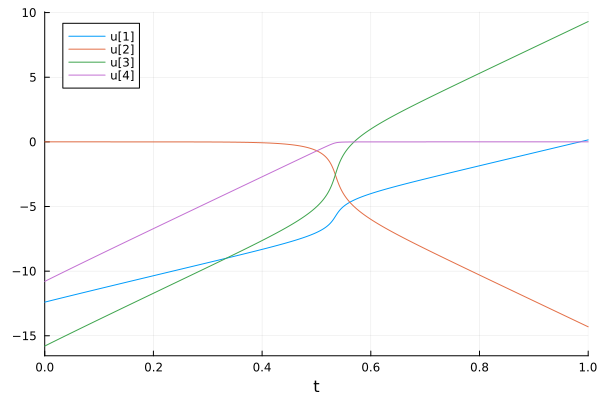

In [ ]:
#--------------------------------------------example usage------------------------------------------------
sol = logx_traj_with_logqK_change(bnc_test, [-10., 0, -9, -5], [10., 0, -9, -5]; reltol=1e-8, abstol=1e-9)
Plots.plot(sol)
#case2--------

In [ ]:

# Pr  SB NB CS CN
N2 = [1 1 0 -1 0 0
    2 1 1 0 -1 0
    1 0 1 0 0 -1]

bnc_test2 = bnc(N=N2)

logx_traj_with_logqK_change(bnc_test2, [], []; input_logspace=false, output_logspace=false)


#case3---------
# @btime let
N3 = N_generator(95, 100; min_binder=2, max_binder=5)
bnc_test3 = bnc(N=N3)

#find ss point
qK = vcat(randomize(bnc_test3.d, -6, 6), randomize(bnc_test3.r, -3, 3))
@btime qK2x(bnc_test3, qK)

qK_end = vcat(randomize(bnc_test3.d, -6, 6), randomize(bnc_test3.r, -3, 0))

@btime let
    bnc_test3 = bnc(N=N3)
    qK2x(bnc_test3, qK)
end
#3.862 3.863
#3.915

relerror = qK2x(bnc_test3, qK; output_logspace=true) |> (x -> x2qK(bnc_test3, x, input_logspace=true)) |> (x -> x ./ qK .- 1)
hist(relerror * 100, bins=100)
# original 1.411s; 14713 allocations; 

@btime sol = logx_traj_with_logqK_change(bnc_test3, log.(qK), log.(qK_end); reltol=1e-8, abstol=1e-9) #bdf solver
plot(sol)
# end

#case4---------

N4 = [0 -1 -1 1 0
    -1 0 0 -1 1]
bnc4 = bnc(N=N4)

x = randomize(bnc4.n * 100000, -6, 6; log_space=true) |> (x -> reshape(x, bnc4.n, 100000))
function rop_C(x)
    ∂logx_∂logqK(bnc4; x=x)[5, 1:3]
end
points = [rop_C(x[:, i]) for i in 1:size(x, 2)] |> (x -> reduce(hcat, x))
# plot the points
fig = Figure(size=(1920, 1080))
ax = Axis3(fig[1, 1],
    title="3D Scatter Plot of Reaction Order Points",
    xlabel="∂logCGRS/∂logtG",
    ylabel="∂logCGRS/∂logtR",
    zlabel="∂logCGRS/∂logtS",
    aspect=:data,
)
GLMakie.scatter!(ax,
    points[1, :], points[2, :], points[3, :];
    color=(:cyan, 0.5), markersize=6)


# case 5----------
N5 = [1 1 0 -1 0 0
    1 0 1 0 -1 0
    # 0 1 0 0 1 -1
    0 0 1 1 0 -1]
bnc5 = bnc(N=N5)


#fucntion test ------------
# qK2x_test(bnc_test,randomize(3,-6,6)) |> (x -> plot!(x, idxs=(1,2,3),legend = false))
model = bnc_test
test_x = [1.e-6, 2e3, 3e-2]
for i in 1:10000
    test_x = x2qK(model, test_x)
    test_x = qK2x(model, test_x)
end

# S_tot_grow
sol = logx_traj_with_logqK_change(bnc_test, [2, -10, 1.0e-9], [2, 10, 1.0e-9], reltol=1e-8, abstol=1e-9)
plot(sol)

logx0 = qK2x(bnc_test, [1.0e1, 1.0e2, 1.0e-1]; output_logspace=true)
time_curve_logx(bnc_test, logx0, (0.0, 150.); reltol=1e-8, abstol=1e-9) |> plot

LoadError: UndefVarError: `bnc` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
Matrix(-I,4,4)

UndefVarError: UndefVarError: `I` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing LinearAlgebra in the current active module Main

In [ ]:
using Symbolics
using Latexify

In [ ]:
@variables x y

2-element Vector{Num}:
 x
 y

In [ ]:
z = x^2 + y

y + x^2

In [ ]:
A = [x^2 + y 0 2x
     0       0 2y
     y^2 + x 0 0]

3×3 Matrix{Num}:
 y + x^2  0  2x
       0  0  2y
 x + y^2  0   0

In [ ]:
latexify(A) |> print

\begin{equation}
\left[
\begin{array}{ccc}
y + x^{2} & 0 & 2 x \\
0 & 0 & 2 y \\
x + y^{2} & 0 & 0 \\
\end{array}
\right]
\end{equation}


In [ ]:
using SparseArrays
spA = sparse(A)
# latexify(A)

3×3 SparseMatrixCSC{Num, Int64} with 4 stored entries:
 y + x^2  ⋅  2x
       ⋅  ⋅  2y
 x + y^2  ⋅   ⋅

In [ ]:
latexify(spA) |> print

\begin{equation}
\left[
\begin{array}{ccc}
y + x^{2} & 0 & 2 x \\
0 & 0 & 2 y \\
x + y^{2} & 0 & 0 \\
\end{array}
\right]
\end{equation}


In [ ]:
function f(u)
  [u[1] - u[3], u[1]^2 - u[2], u[3] + u[2]]
end
f([x, y, z])

3-element Vector{Num}:
 x - y - (x^2)
      -y + x^2
      2y + x^2

In [ ]:
@variables a, b,c

3-element Vector{Num}:
 a
 b
 c

In [ ]:
simplify(a-b +b^2- b)

a - 2b + b^2

In [ ]:
u = Symbolics.variables(:u, 1:5)
f(u)

3-element Vector{Num}:
    u₁ - u₃
 -u₂ + u₁^2
    u₂ + u₃

In [ ]:
f([1,2,3,4])

3-element Vector{Int64}:
 -2
 -1
  5

In [ ]:
f([1,2,2,3,3.])

3-element Vector{Float64}:
 -1.0
 -1.0
  4.0

In [ ]:
@variables t
D = Differential(t)

Differential(t)

In [ ]:
z = exp(t) + log(t)
D(z)

Differential(t)(exp(t) + log(t))

In [ ]:
expand_derivatives(D(z))

1 / t + exp(t)

In [ ]:
simplify(2x + 2y)

2(x + y)

In [ ]:
B = simplify.([t + t^2 + t + t^2  2t + 4t
               x + y + y + 2t     x^2 - x^2 + y^2])

2×2 Matrix{Num}:
   2(t + t^2)   6t
 2(t + y) + x  y^2

In [ ]:
simplify.(substitute.(B, (Dict(x => y^2),)))

2×2 Matrix{Num}:
     2(t + t^2)   6t
 2(t + y) + y^2  y^2

In [ ]:
V = substitute.(B, (Dict(x => 2., y => 3, t => 4),))

2×2 Matrix{Num}:
     40  24
 14 + x   9

In [ ]:
L = [1 0 2 1 2
    0 1 0 1 1]
x = Symbolics.variables(:x, 1:5)

5-element Vector{Num}:
 x₁
 x₂
 x₃
 x₄
 x₅

In [ ]:
a = Symbolics.variables("a",1:1)

1-element Vector{Num}:
 a₁

In [ ]:
Symbolics.value.(V)

2×2 Matrix{Any}:
 40        24
   14 + x   9

In [ ]:
x,y,z = :x, :y, :z

(:x, :y, :z)

In [ ]:
vars = @variables t $x $y(t) $z(t)[1:3]

4-element Vector{Any}:
    t
    x
 y(t)
     (z(t))[1:3]

In [ ]:
@variables a b
Symbolics.toexpr(a + b^2)

:((+)(a, (^)(b, 2)))

In [ ]:
ex = [:(v ~ w)
      :(w ~ -v)]

2-element Vector{Expr}:
 :(v ~ w)
 :(w ~ -v)

In [ ]:
eqs = parse_expr_to_symbolic.(ex, (Main,))

2-element Vector{Equation}:
 v ~ w
 w ~ -v

In [ ]:
eqs_lhs = [eq.lhs for eq in eqs]

2-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 v
 w

In [ ]:
eqs_rhs = [eq.rhs for eq in eqs]

2-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 w
 -v

In [ ]:
Symbolics.jacobian(eqs_rhs, eqs_lhs)

2×2 Matrix{Num}:
  0  1
 -1  0

In [ ]:
k = @variables t x(t) y(t) 

3-element Vector{Num}:
    t
 x(t)
 y(t)

In [ ]:
z = x + y*t
D(z)

Differential(t)(x(t) + t*y(t))

In [ ]:
expand_derivatives(D(z))

y(t) + Differential(t)(x(t)) + t*Differential(t)(y(t))

In [ ]:
@variables g(..)

1-element Vector{Symbolics.CallWithMetadata{SymbolicUtils.FnType{Tuple, Real}, Base.ImmutableDict{DataType, Any}}}:
 g⋆

In [ ]:
z = g(x,y) +g(x)+g(y)

g(y(t)) + g(x(t)) + g(x(t), y(t))

In [ ]:
f(x, y) = x^2 + y
f(x, y) + y^2

y(t) + x(t)^2 + y(t)^2

In [ ]:
h(x, y) = f(x, y)

@register_symbolic h(x, y)

In [ ]:
h(x, y) + y^2

Main.h(x(t), y(t)) + y(t)^2

In [ ]:
#Manually register its derivatives
# Derivative w.r.t. the first argument
Symbolics.derivative(::typeof(h), args::NTuple{2,Any}, ::Val{1}) = 2args[1]
# Derivative w.r.t. the second argument
Symbolics.derivative(::typeof(h), args::NTuple{2,Any}, ::Val{2}) = 1

In [ ]:
Symbolics.derivative(h(x, y) + y^2, x)

2x(t)

In [ ]:
Symbolics.derivative(h(x, y) + y^2, y)

1 + 2y(t)

In [ ]:
using SymbolicUtils

In [ ]:
@syms w::Real z 

(w, z)

In [ ]:
@syms w::Real
Symbolics.simplify(log(exp(w)))

log(exp(w))

In [ ]:
using SymbolicUtils
rlogexp = @rule log(exp(~x)) => ~x
rewriter = [rlogexp] |> Chain |> Postwalk

SymbolicUtils.Rewriters.Walk{:post, Chain, typeof(TermInterface.maketerm), false}(Chain(SymbolicUtils.Rule{SymbolicUtils.BasicSymbolic{Any}, SymbolicUtils.var"#term_matcher#119"{Tuple{SymbolicUtils.var"#literal_matcher#115"{typeof(log)}, SymbolicUtils.var"#term_matcher#119"{Tuple{SymbolicUtils.var"#literal_matcher#115"{typeof(exp)}, SymbolicUtils.var"#slot_matcher#116"{SymbolicUtils.Slot{typeof(SymbolicUtils.alwaystrue)}}}}}}, var"#194#195"}[log(exp(~x)) => ~x], false), 100, TermInterface.maketerm)

In [ ]:
simplified_expr = simplify(log(exp(x)) + 3, rewriter)

3 + x

In [ ]:
using SymbolicUtils: symtype
symtype(x)

Real

In [ ]:
simplify(log(exp(x+3)), rewriter=rlogexp) 

3 + x

In [ ]:
simplify(log(exp(x))+3, rewriter=rlogexp)

3 + log(exp(x))

In [ ]:
using Symbolics

# Define a symbolic variable
@variables w

# Define the expression
expr = exp(log(w))

# Define the simplification rule
r = @rule exp(log(~x)) => ~x

# Apply the simplification with the custom rule
simplified_expr = simplify(expr, rewriter=r)

println(simplified_expr)

w


In [ ]:
?simplify

search: simplify sympy_simplify sinpi split symdiff display SimplifiedEM similar



  simplify(x; expand=false,
              threaded=false,
              thread_subtree_cutoff=100,
              rewriter=nothing)

  Simplify an expression (x) by applying rewriter until there are no changes.
  expand=true applies expand (/api/#expand) in the beginning of each fixpoint
  iteration.

  By default, simplify will assume denominators are not zero and allow
  cancellation in fractions. Pass simplify_fractions=false to prevent this.

In [ ]:
using Graphs
function graph_generator(L)
    d, n = size(L)
    M1 = [zeros(Int, d, d)  L ; L' zeros(Int, n, n)]
    G = SimpleGraph(M1)
    return G
end

#----------

# Print the results
# println("Number of possible M matrices: ", length(matrices_M))
# for (idx, M) in enumerate(matrices_M)
#     println("\nM_$idx:")
#     println(M)
# end



using GLMakie, GraphMakie
using GraphMakie.NetworkLayout
# - ------

# L = [1 0 0 1 1 0 ; 0 1 0 1 0 1 ; 0 0 1 0 1 1]
# L = [1 0 1 1; 0 1 1 1]
# L = L_generator(10,20,min_binder=2,max_binder=2) 
L = L_generator(18,40)
# Example matrix
# valids = find_valid_regime(L)
let
d,n = size(L)
# M = idx_to_vertex(L, valids[16])
# G = graph_generator(M)
G = graph_generator(L)

p = graphplot(G; layout = Stress(;dim=3),
    node_size = 20 , node_color = vcat([:blue for i in 1:d],[:red for i in 1:n]), edge_color = :black,
    nlabels = vcat(["U"*string(i) for i in 1:d],["V"*string(i) for i in 1:n]),
    # edge_label = [string(i) for i in 1:ne(G)],
    # camera = (zoom=0.5, elevation=0.5, azimuth=0.5),
    # axis = (aspect=DataAspect(), title="Graph Plot")
)
display(p)
# M
end

GLMakie.Screen(...)

In [ ]:
bnc_test._valid_L_idx

2-element Vector{Vector{Int64}}:
 [1, 3, 4]
 [2, 4]

In [ ]:
bnc_test.L

2×4 Matrix{Int64}:
 1  0  2  2
 0  1  0  1